# DS - Healthcare - Persistency of a drug

-   Problem understanding
-   Data Understanding
-   Data Cleaning and Feature engineering
-   Model Development
-   Model Selection
-   Model Evaluation
-   Report the accuracy, precision and recall of both the class of target variable
-   Report ROC-AUC as well
-   Deploy the model
-   Explain the challenges and model selection

In [39]:
import sys
import random
import pickle
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from copy import deepcopy
import matplotlib.pyplot as plt

from scipy.spatial import distance, ConvexHull
from scipy.sparse import coo_matrix, hstack, csr_matrix

import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

import keras
from keras import callbacks
import tensorflow as tf


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

mpl.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
# %matplotlib notebook
sns.set()

# for google drive, uncommenct them if not drive
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/DataGlacier_FP')

%cd /content/drive/My Drive/DataGlacier_FP/

from preprocess import *

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DataGlacier_FP
corr.csv     Docs	Healthcare_dataset.xlsx  __pycache__
Dataset.csv  EDA.ipynb	preprocess.py


## Read Data

In [40]:
dict_df = pd.read_excel('Healthcare_dataset.xlsx', sheet_name=['Feature Description','Dataset'])

df_fd=dict_df.get('Feature Description').fillna(method="ffill")
raw_df=dict_df['Dataset'].drop('Ptid',axis=1)

In [41]:
colnames=raw_df.columns
label='Persistency_Flag'
inde_colnames=[col for col in colnames if col !=label]

num_colnames=[]
str_colnames=[]
for col in colnames:
    if raw_df[col].dtype=='object':
        str_colnames.append(col)
    else:
        num_colnames.append(col)

print('string colnames:',str_colnames)
print('number colnames:',num_colnames)

string colnames: ['Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure', 'Comorb_Disor

In [42]:
raw_df.shape

(3424, 68)

In [43]:
df,map_cs=hard_code(raw_df,str_colnames)

In [44]:
def show_dexa(col,bins):

    plt.figure(figsize=(20,8))
    plt.subplot(2, 2, 1)
    plt.hist(df[col]);

    plt.subplot(2, 2, 2)
    df[col].plot(kind='box');

    plt.subplot(2, 1, 2)
    plt.title("Probability Density Distribution")
    plt.hist(df[df.Persistency_Flag==0][col], bins, density = True, alpha = 0.5, label='Non-Persistent');
    plt.hist(df[df.Persistency_Flag==1][col], bins, density = True, alpha = 0.5, label='Persistent');
    plt.legend(loc='upper right');

In [45]:
df.head()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,1,1,2,1,4,3,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,4,0,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,1,5,0,1,0,...,0,1,0,0,0,0,0,0,0,2
3,0,0,2,1,0,3,5,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,2,1,0,3,5,0,1,1,...,0,0,0,0,0,0,0,0,0,1


### "Dexa_Freq_During_Rx" process

#### details

In [46]:
df["Dexa_Freq_During_Rx"]

0       0
1       0
2       0
3       0
4       0
       ..
3419    0
3420    0
3421    7
3422    0
3423    0
Name: Dexa_Freq_During_Rx, Length: 3424, dtype: int64

In [47]:
df["Dexa_Freq_During_Rx"].value_counts().sort_index()

0      2488
1        24
2        24
3        46
4        68
5       114
6       107
7        93
8        71
9        32
10       55
11       30
12       52
13       19
14       38
15        9
16       14
17        7
18       14
19        3
20       15
21        7
22       13
23        1
24       10
25        2
26       10
27        1
28        7
29        1
30        7
32        3
33        1
34        3
35        1
36        5
37        1
38        1
39        2
40        1
42        3
44        1
45        1
48        2
50        1
52        2
54        1
58        2
66        1
68        1
69        1
72        1
81        1
88        2
108       1
110       1
118       1
146       1
Name: Dexa_Freq_During_Rx, dtype: int64

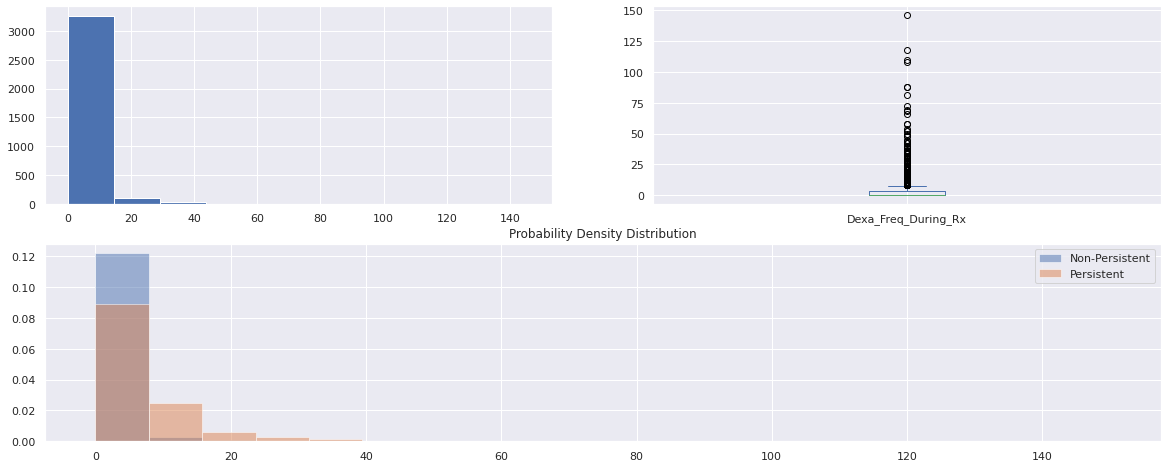

In [48]:
col="Dexa_Freq_During_Rx"
bins = np.linspace(0, 150, 20)
show_dexa(col,bins)

In [49]:
df["log_Dexa_Freq_During_Rx"]=np.log(1+df["Dexa_Freq_During_Rx"]);

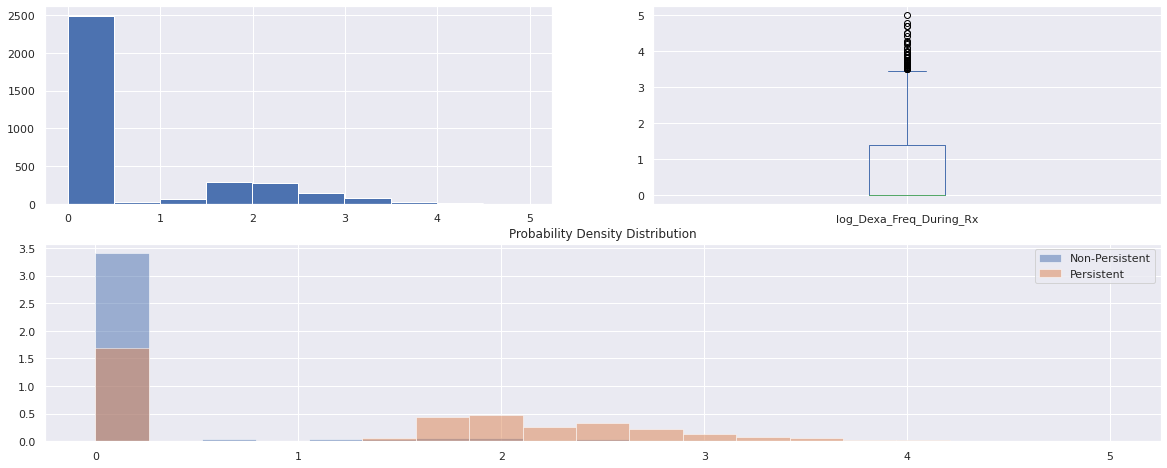

In [50]:
col="log_Dexa_Freq_During_Rx"
bins = np.linspace(0, 5, 20)
show_dexa(col,bins)

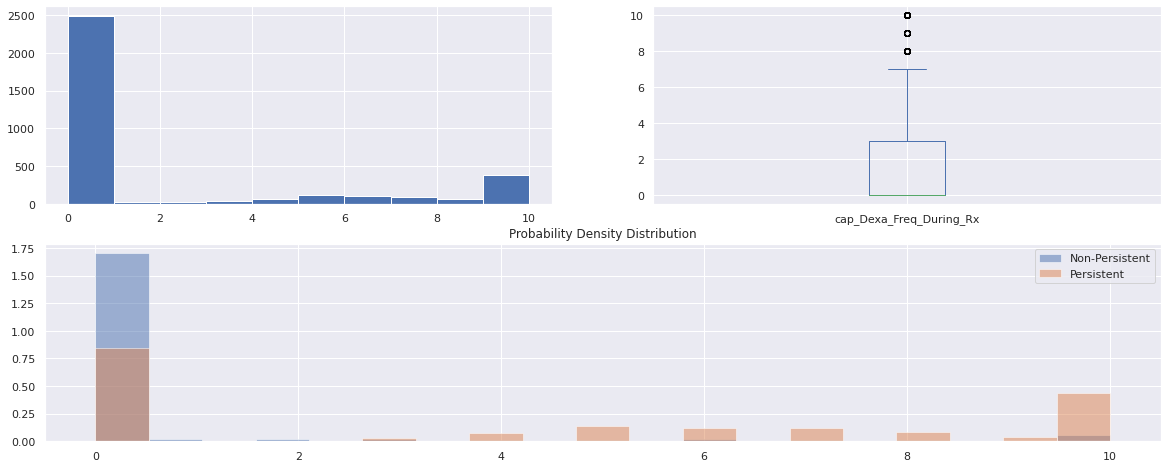

In [51]:
## capping
thre=10 # 30
df["cap_Dexa_Freq_During_Rx"]=df["Dexa_Freq_During_Rx"]
df["cap_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] >= thre] = thre


col="cap_Dexa_Freq_During_Rx"
bins = np.linspace(0, thre, 20)
show_dexa(col,bins)

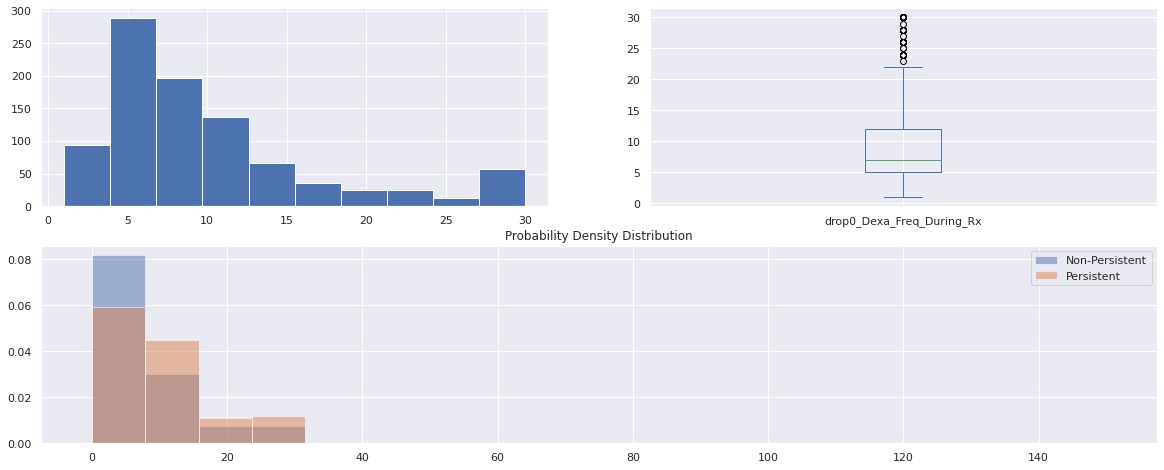

In [52]:
df["drop0_Dexa_Freq_During_Rx"]=df["Dexa_Freq_During_Rx"]
df["drop0_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] == 0] = None

df["drop0_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] >= 30] = 30

col="drop0_Dexa_Freq_During_Rx"
bins = np.linspace(0, 150, 20)
show_dexa(col,bins)

In [53]:
## bin
# pd.qcut(df['Dexa_Freq_During_Rx'], q=[0,])
df['bin_Dexa_Freq_During_Rx']=pd.cut(df['Dexa_Freq_During_Rx'], bins=[0, 1, 5, 8, 15, 27,150], right=False)

In [54]:
df.groupby([label,'bin_Dexa_Freq_During_Rx'])[label].count().unstack('bin_Dexa_Freq_During_Rx').columns

CategoricalIndex([[0, 1), [1, 5), [5, 8), [8, 15), [15, 27), [27, 150)], categories=[[0, 1), [1, 5), [5, 8), [8, 15), [15, 27), [27, 150)], ordered=True, dtype='category', name='bin_Dexa_Freq_During_Rx')

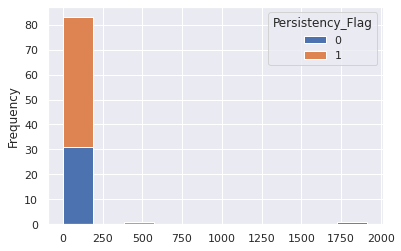

In [55]:
df.groupby(['Dexa_Freq_During_Rx', label]).size().unstack().plot(kind='hist', stacked=True);

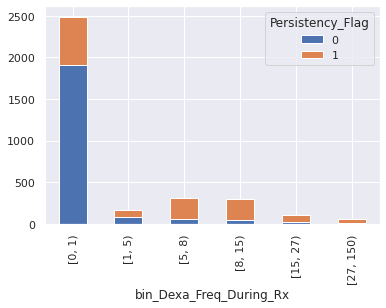

In [56]:
df.groupby(['bin_Dexa_Freq_During_Rx', label]).size().unstack().plot(kind='bar', stacked=True);

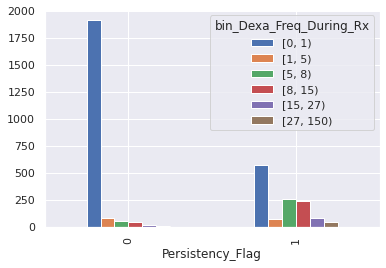

In [57]:
contb = pd.crosstab(df[label], df['bin_Dexa_Freq_During_Rx'])
barplot=contb.plot.bar()

# EDA

In [70]:
from math import sqrt,floor,ceil

def plot_stacked_bars(df,colnames):
    l=len(colnames)
    w=int(sqrt(l))
    d=ceil(l/w)
    plt.figure(figsize=(d*7,w*7))
    for i in range(1,l+1):
        col=colnames[i-1]
        ax=plt.subplot(w,d,i)
        flag_legend=True# if i==l else False
        df.groupby([col, label]).size().unstack().plot(kind='bar', stacked=True, rot=10,ax=ax,legend=flag_legend);


def corr_heatmap(corr,cols=None,annot=True):
    if not cols: cols=corr.columns 
    if label not in cols: cols+=[label]
    temp=corr.loc[cols,cols]

    f, ax= plt.subplots(figsize = (8, 6))
    sns.heatmap(temp,vmax=1.0, vmin=-1.0, cmap='coolwarm', linewidths = 0.02, ax = ax, annot=annot);

## Dexa Freq During Rx

In [60]:
df["log_Dexa_Freq_During_Rx"]=np.log(1+df["Dexa_Freq_During_Rx"]);


## capping
thre=10 # 30
df["cap_Dexa_Freq_During_Rx"]=df["Dexa_Freq_During_Rx"]
df["cap_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] >= thre] = thre


df["drop0_Dexa_Freq_During_Rx"]=df["Dexa_Freq_During_Rx"]
df["drop0_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] == 0] = None

df["drop0_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] >= 30] = 30


## bin
# pd.qcut(df['Dexa_Freq_During_Rx'], q=[0,])
df['bin_Dexa_Freq_During_Rx']=pd.cut(df['Dexa_Freq_During_Rx'], bins=[0, 1, 5, 8, 15, 27,150], right=False)

scalar=StandardScaler()

cor_df=df.copy()
cor_df[inde_colnames]=scalar.fit_transform(df[inde_colnames])

corr = cor_df.corr()

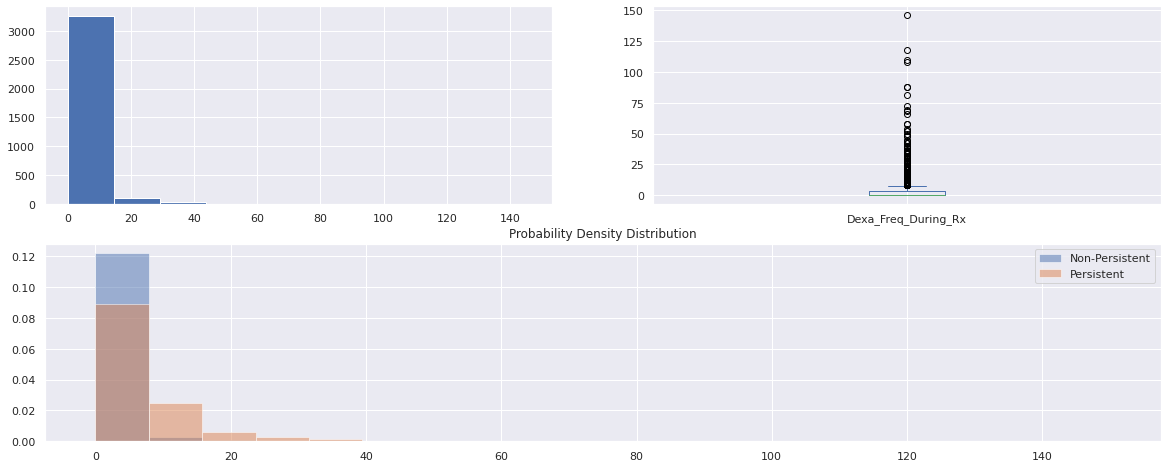

In [61]:
col="Dexa_Freq_During_Rx"
bins = np.linspace(0, 150, 20)
show_dexa(col,bins)

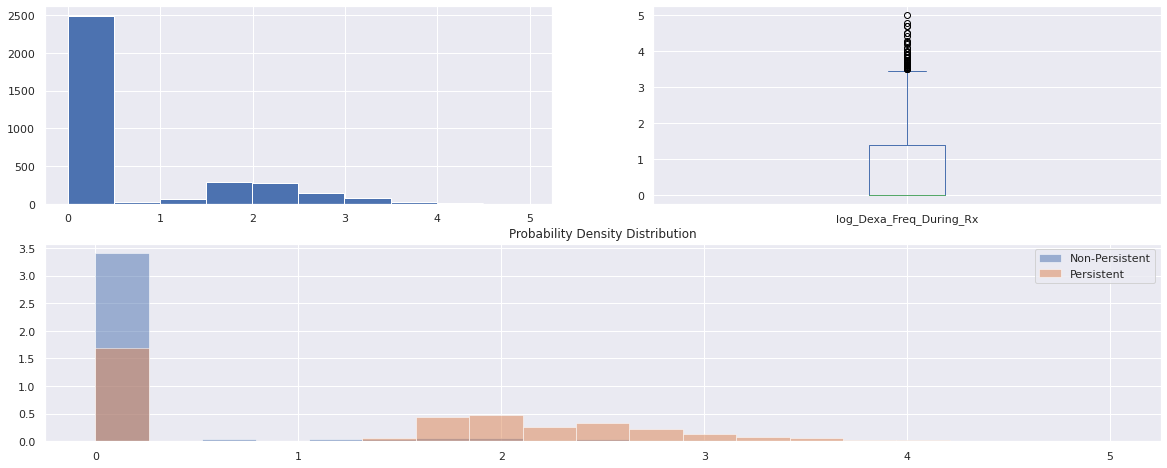

In [62]:
col="log_Dexa_Freq_During_Rx"
bins = np.linspace(0, 5, 20)
show_dexa(col,bins)

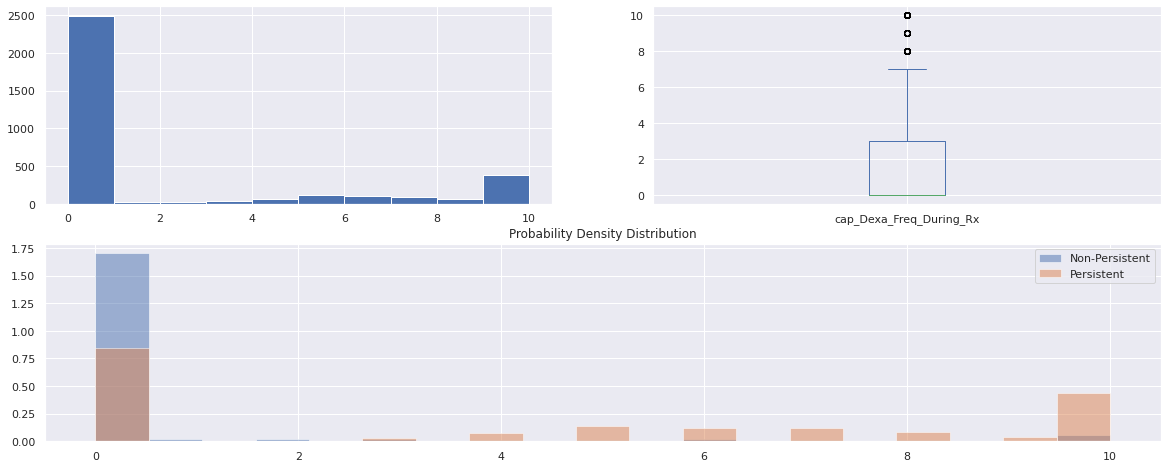

In [63]:
col="cap_Dexa_Freq_During_Rx"
bins = np.linspace(0, thre, 20)
show_dexa(col,bins)

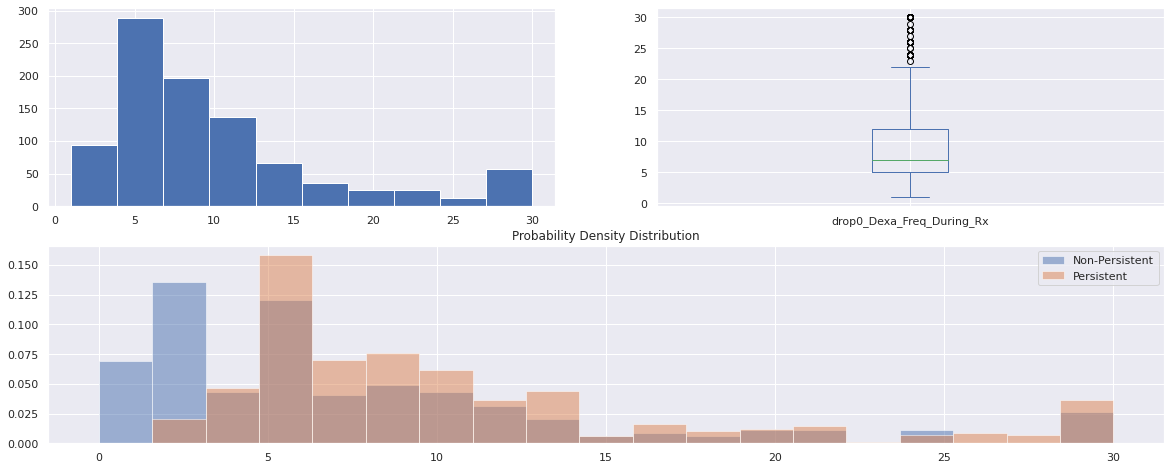

In [64]:
col="drop0_Dexa_Freq_During_Rx"
bins = np.linspace(0, 30, 20)
show_dexa(col,bins)

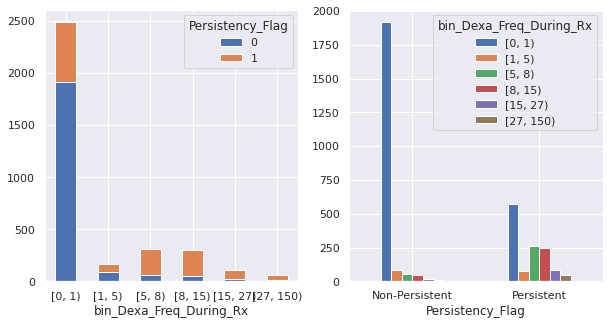

In [65]:
plt.figure(figsize=(10,5))
ax=plt.subplot(1,2,1)
df.groupby(['bin_Dexa_Freq_During_Rx', label]).size().unstack().plot(kind='bar', stacked=True, rot=0,ax=ax);
ax=plt.subplot(1,2,2)
contb = pd.crosstab(raw_df[label], df['bin_Dexa_Freq_During_Rx'])
barplot=contb.plot.bar(rot=0,ax=ax);

In [66]:
colnames

Index(['Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Pers

## Demographics

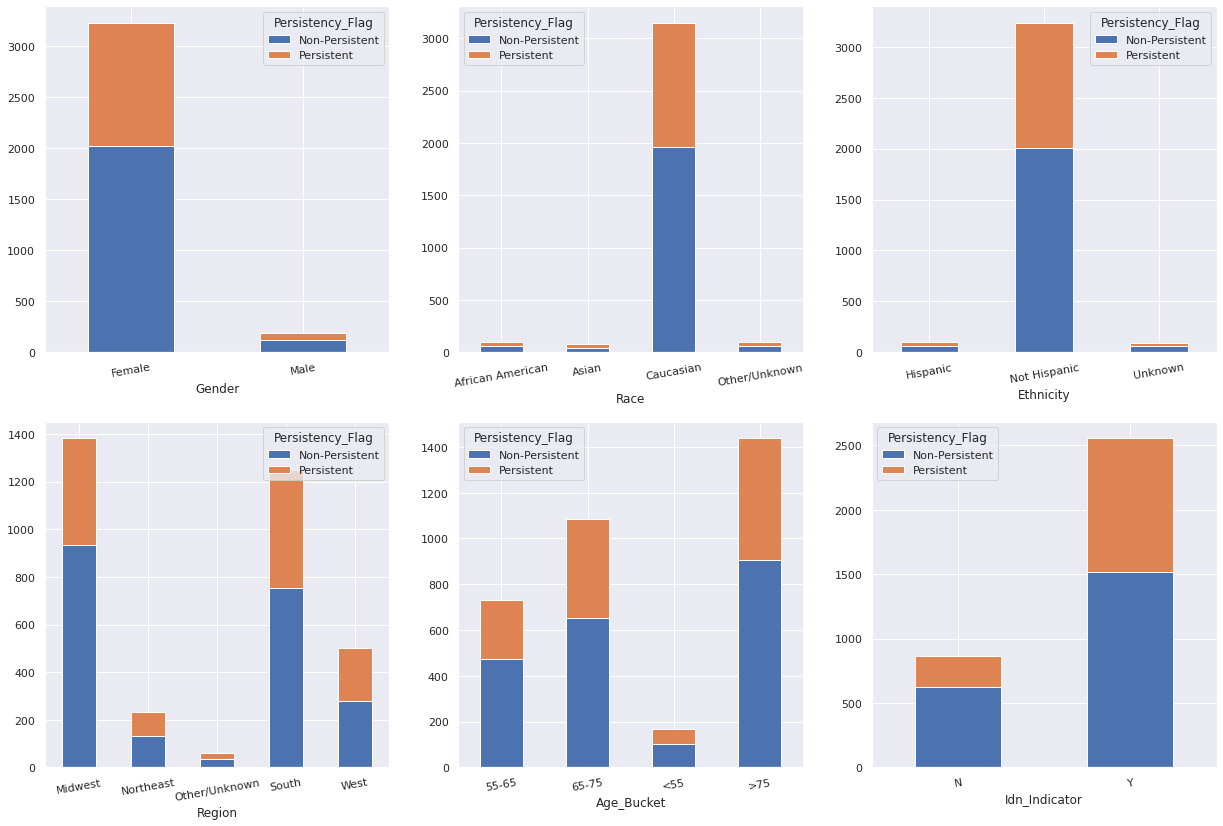

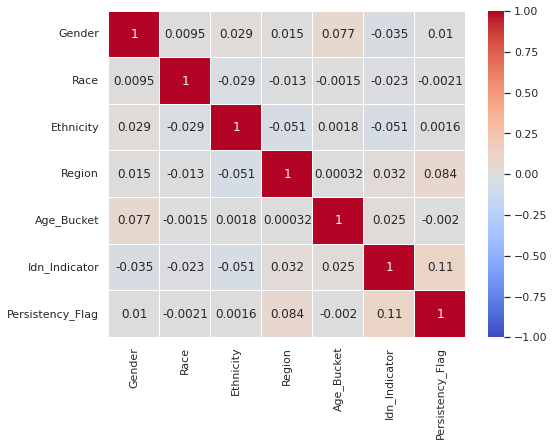

In [71]:
demog_colnames=[ 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket','Idn_Indicator']

plot_stacked_bars(raw_df,demog_colnames)

corr_heatmap(corr,demog_colnames)

## Provider Attributes

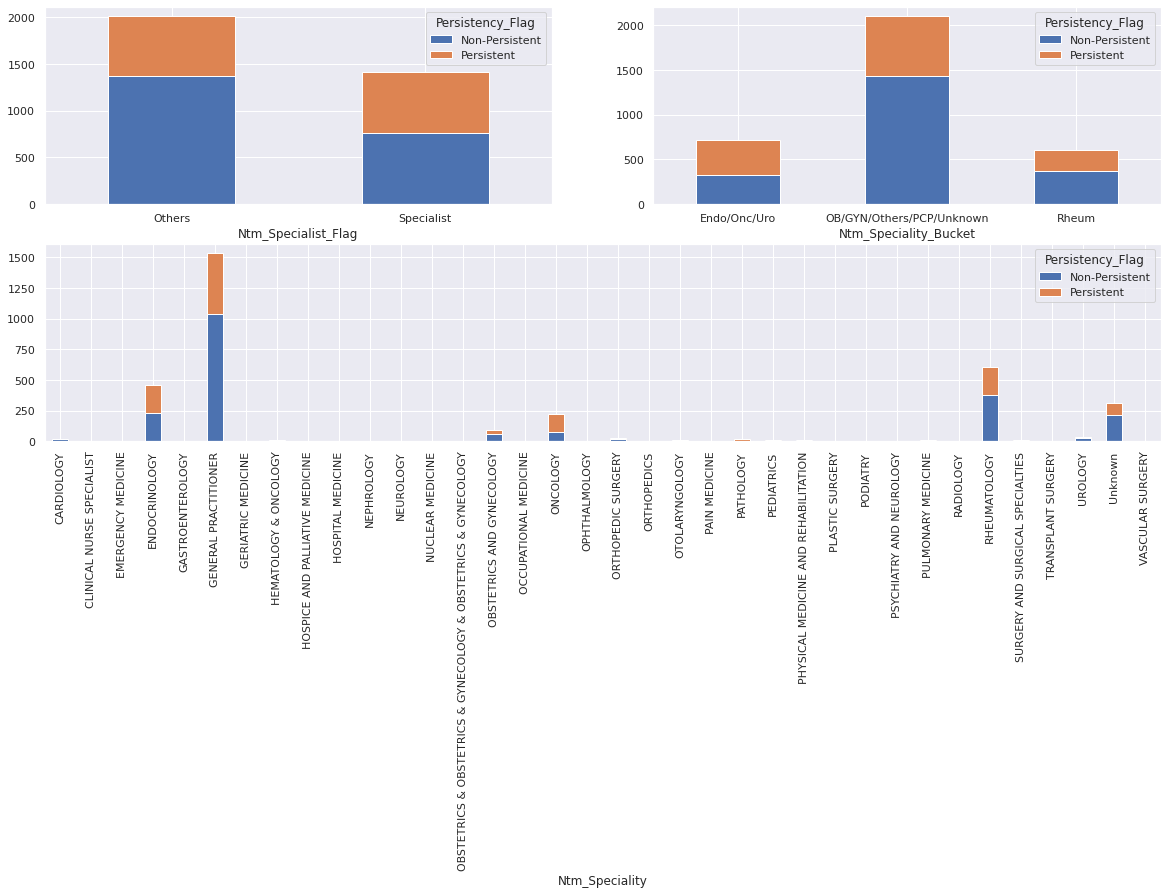

In [72]:
provider_colnames=[c for c in colnames if c.startswith("Ntm")]


plt.figure(figsize=(20,8))
ax=plt.subplot(2, 2, 1)
raw_df.groupby(["Ntm_Specialist_Flag", label]).size().unstack().plot(kind='bar', stacked=True, rot=0,ax=ax,legend=True);

ax=plt.subplot(2, 2, 2)
raw_df.groupby(["Ntm_Speciality_Bucket", label]).size().unstack().plot(kind='bar', stacked=True, rot=0,ax=ax,legend=True);


ax=plt.subplot(2, 1, 2)
raw_df.groupby(["Ntm_Speciality", label]).size().unstack().plot(kind='bar', stacked=True, rot=90,ax=ax,legend=True);

According to this, we will choose "Ntm_Speciality"

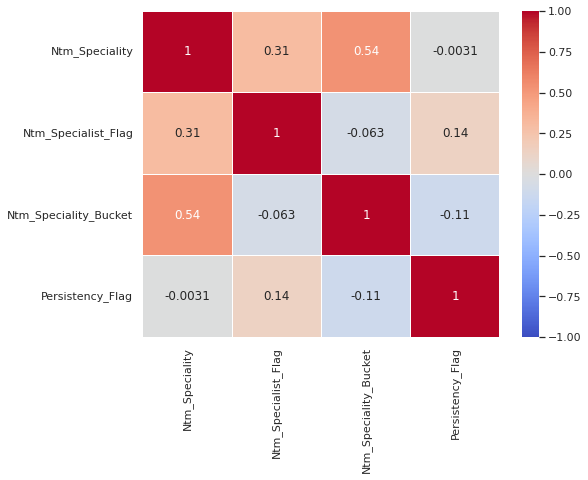

In [73]:
corr_heatmap(corr,provider_colnames)

## Clinical Factors

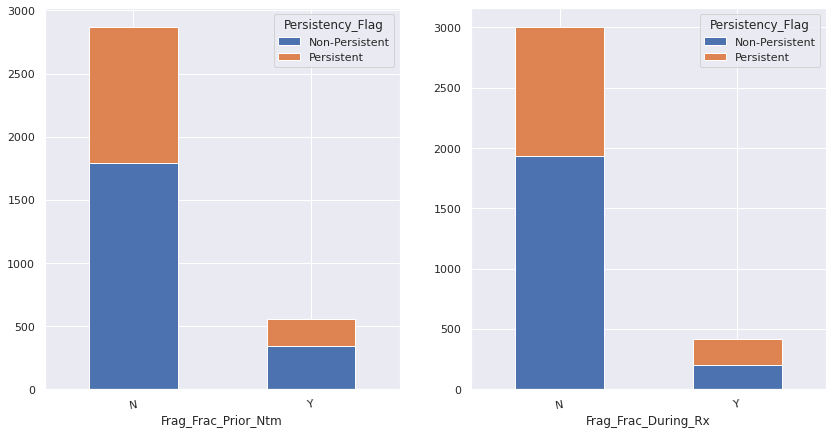

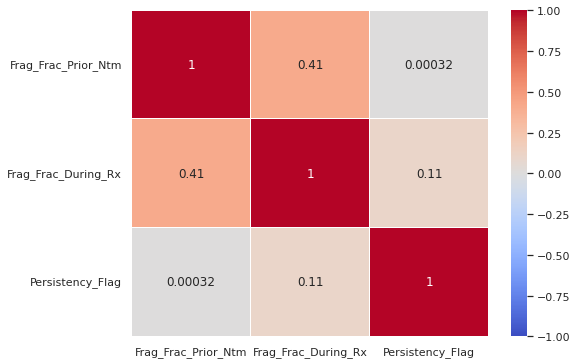

In [74]:
frag_colnames=[c for c in colnames if c.startswith("Frag")]

plot_stacked_bars(raw_df,frag_colnames)

corr_heatmap(corr,frag_colnames)

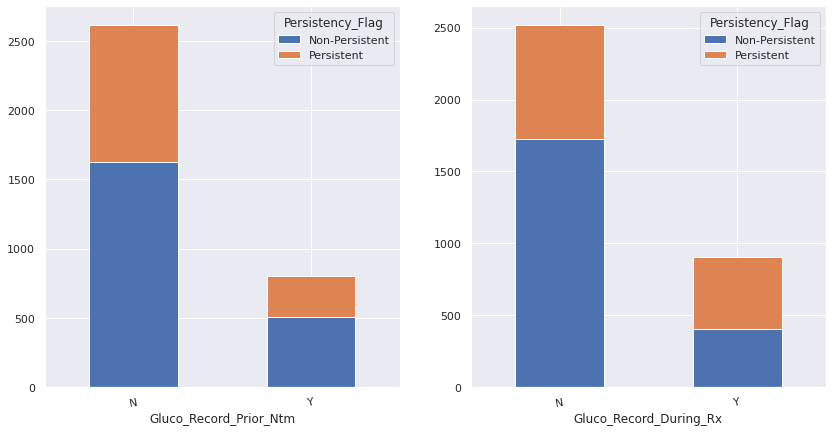

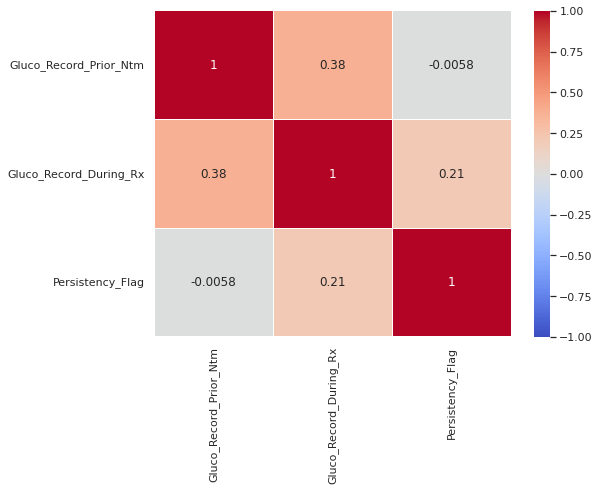

In [75]:
gluco_colnames=[c for c in colnames if c.startswith("Gluco")]

plot_stacked_bars(raw_df,gluco_colnames)

corr_heatmap(corr,gluco_colnames)

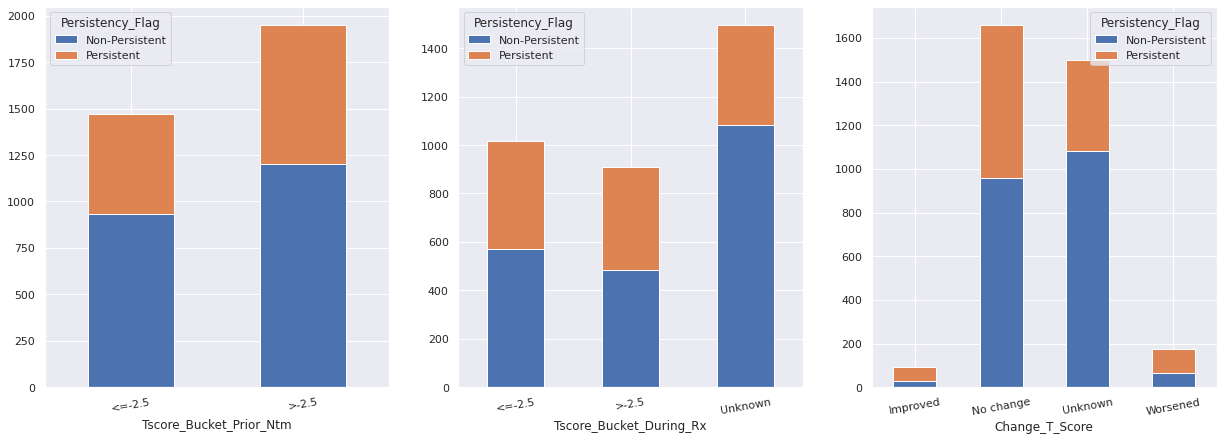

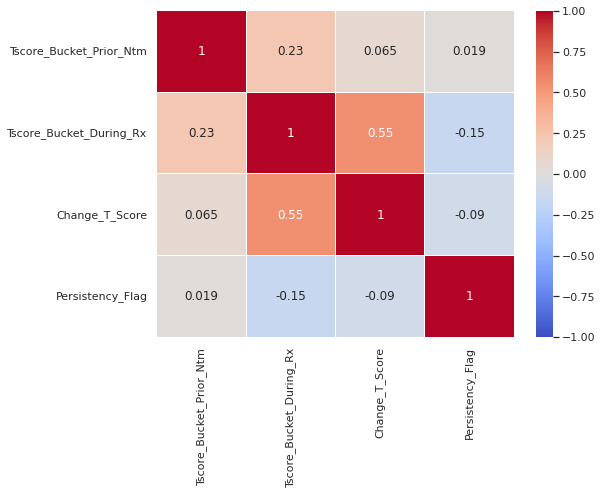

In [76]:
tscore_colnames=[c for c in colnames if c.startswith("Tscore")]+["Change_T_Score"]

plot_stacked_bars(raw_df,tscore_colnames)

corr_heatmap(corr,tscore_colnames)

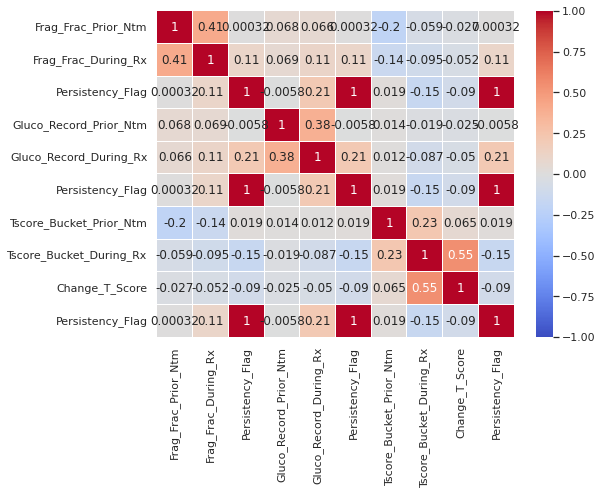

In [77]:
corr_heatmap(corr,frag_colnames+gluco_colnames+tscore_colnames)

## Disease/Treatment Factor

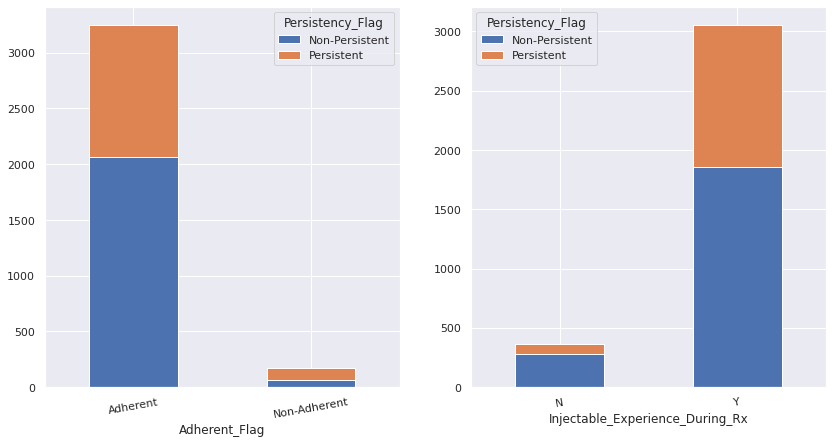

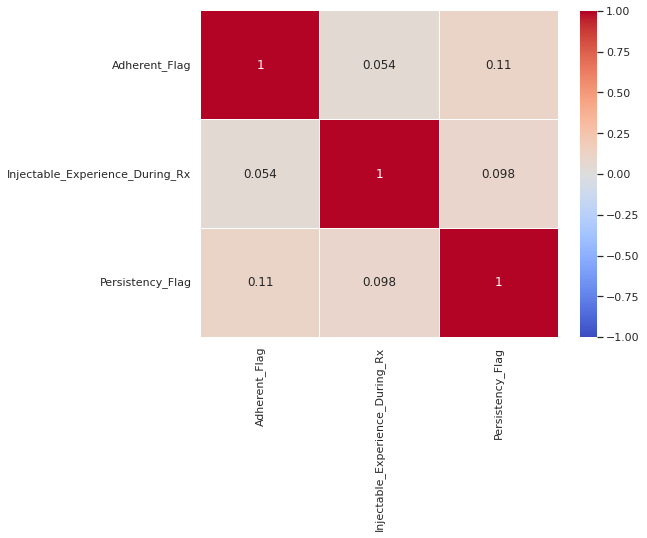

In [78]:
other_disease_colnames=["Adherent_Flag","Injectable_Experience_During_Rx"]

plot_stacked_bars(raw_df,other_disease_colnames)

corr_heatmap(corr,other_disease_colnames)

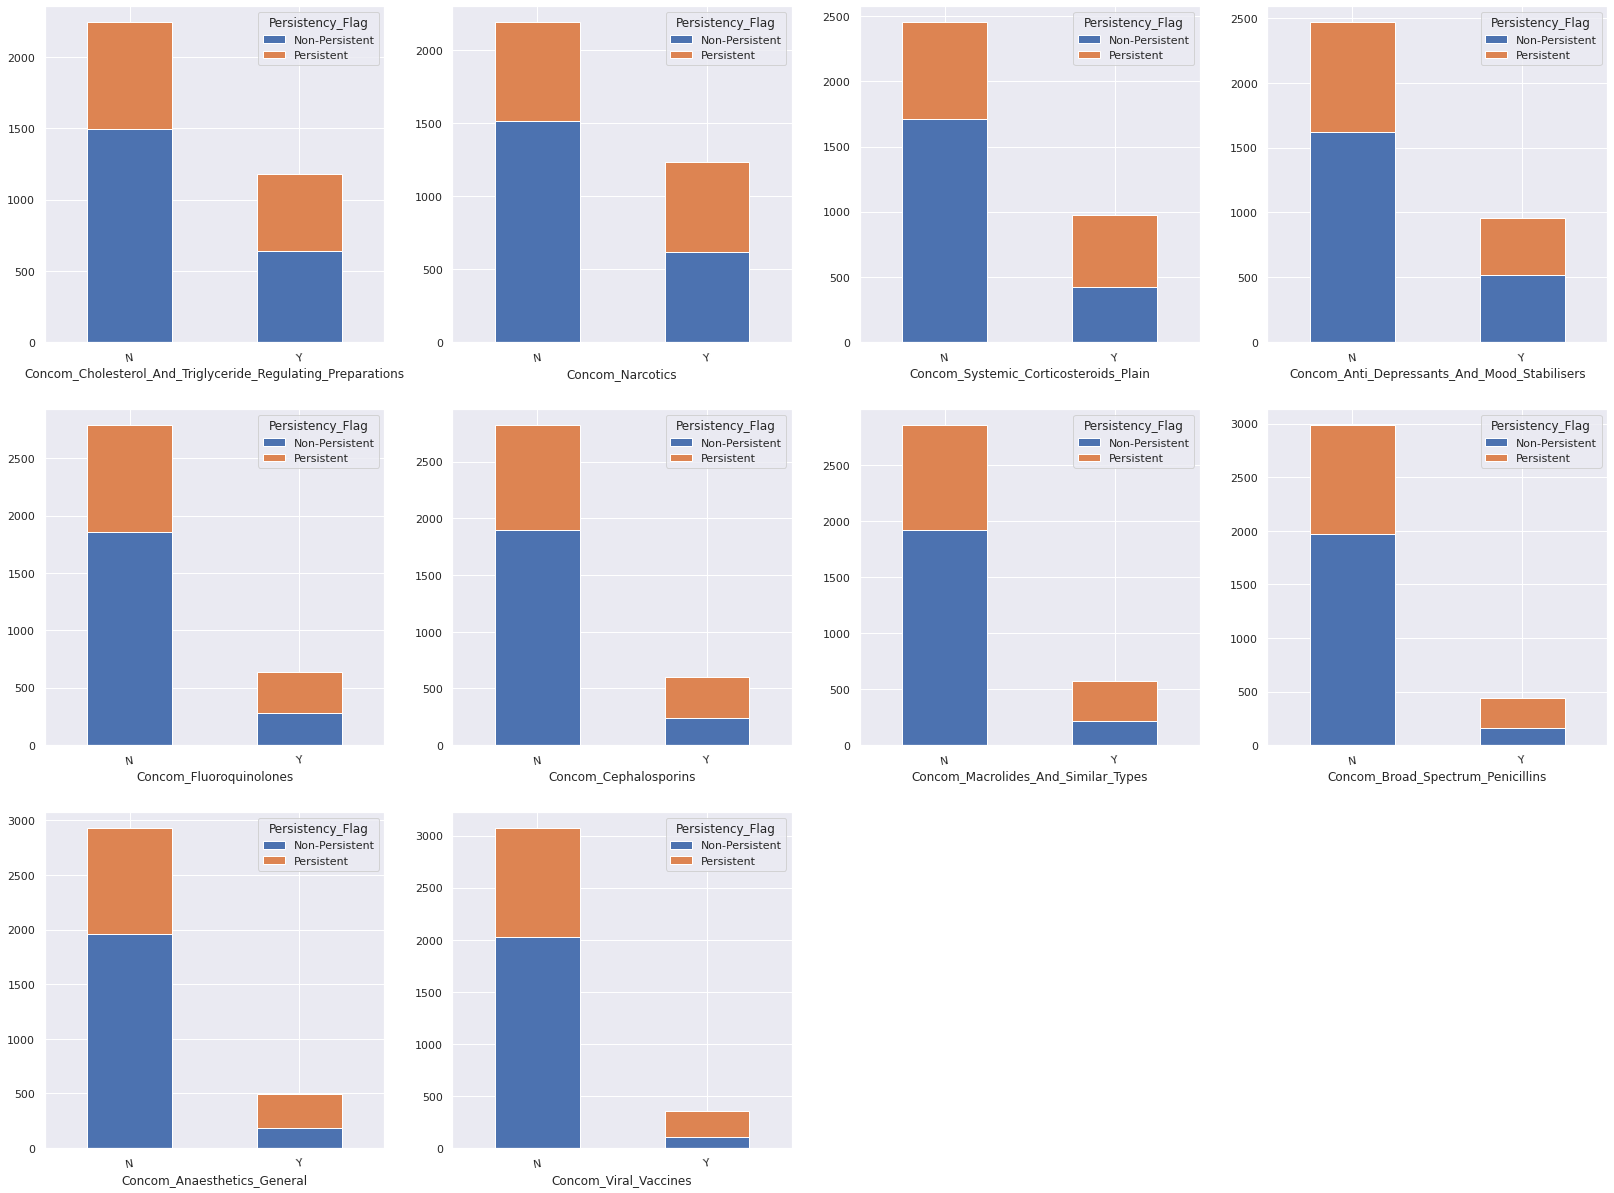

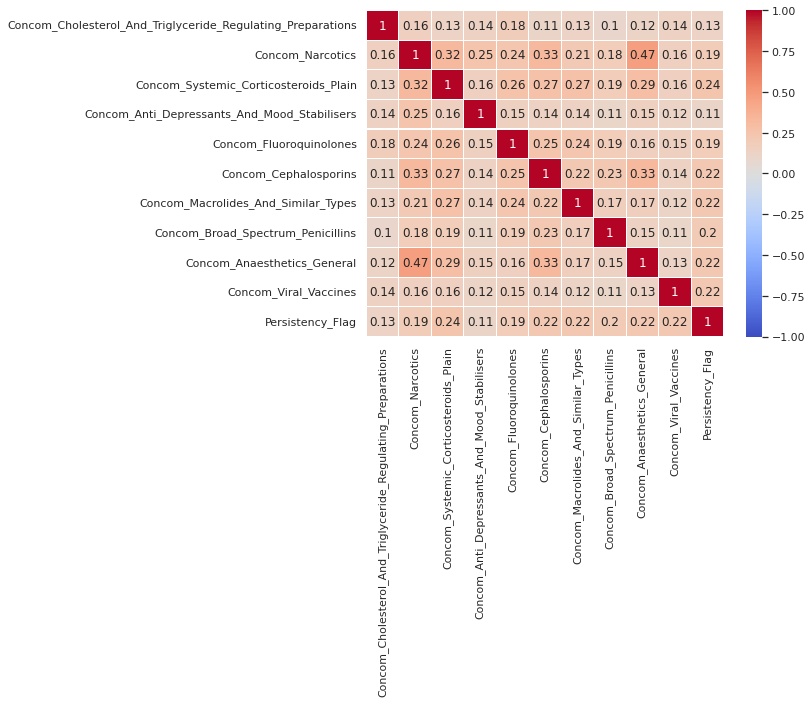

In [79]:
concom_colnames=[c for c in colnames if c.startswith("Concom")]

plot_stacked_bars(raw_df,concom_colnames)

corr_heatmap(corr,concom_colnames)

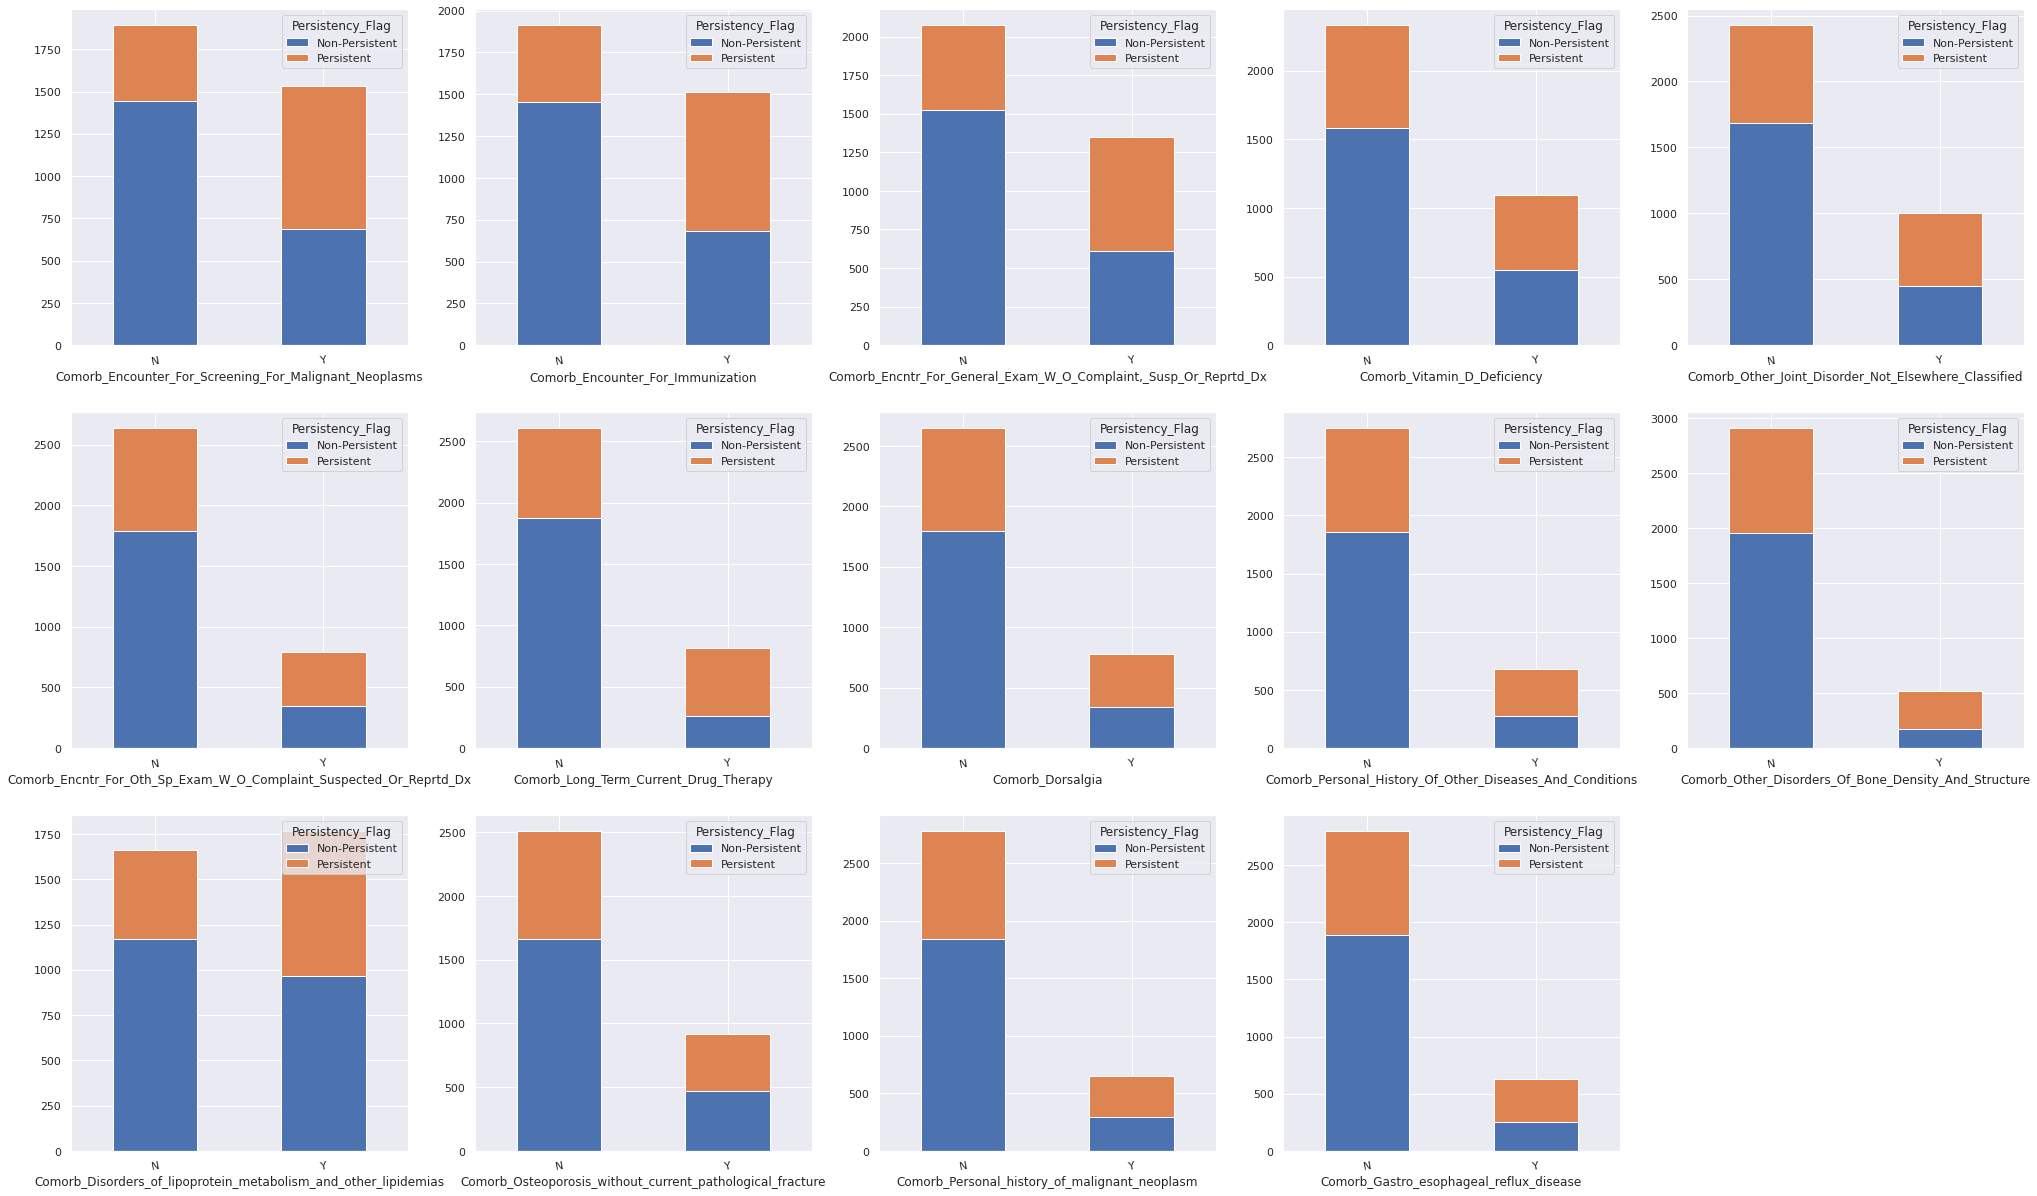

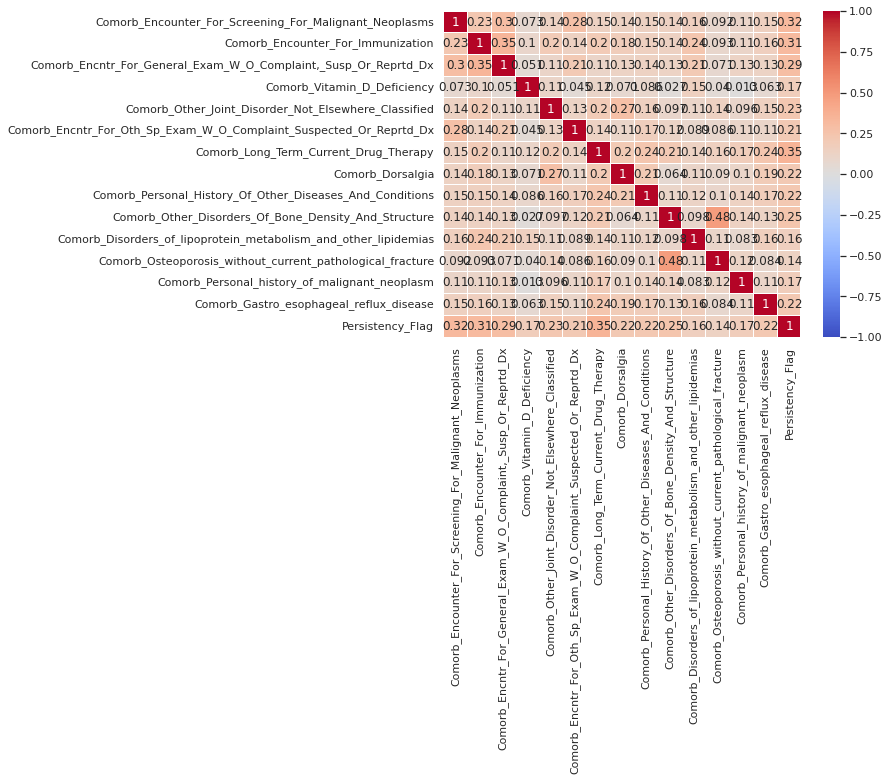

In [80]:
comorb_colnames=[c for c in colnames if c.startswith("Comorb")]

plot_stacked_bars(raw_df,comorb_colnames)

corr_heatmap(corr,comorb_colnames)

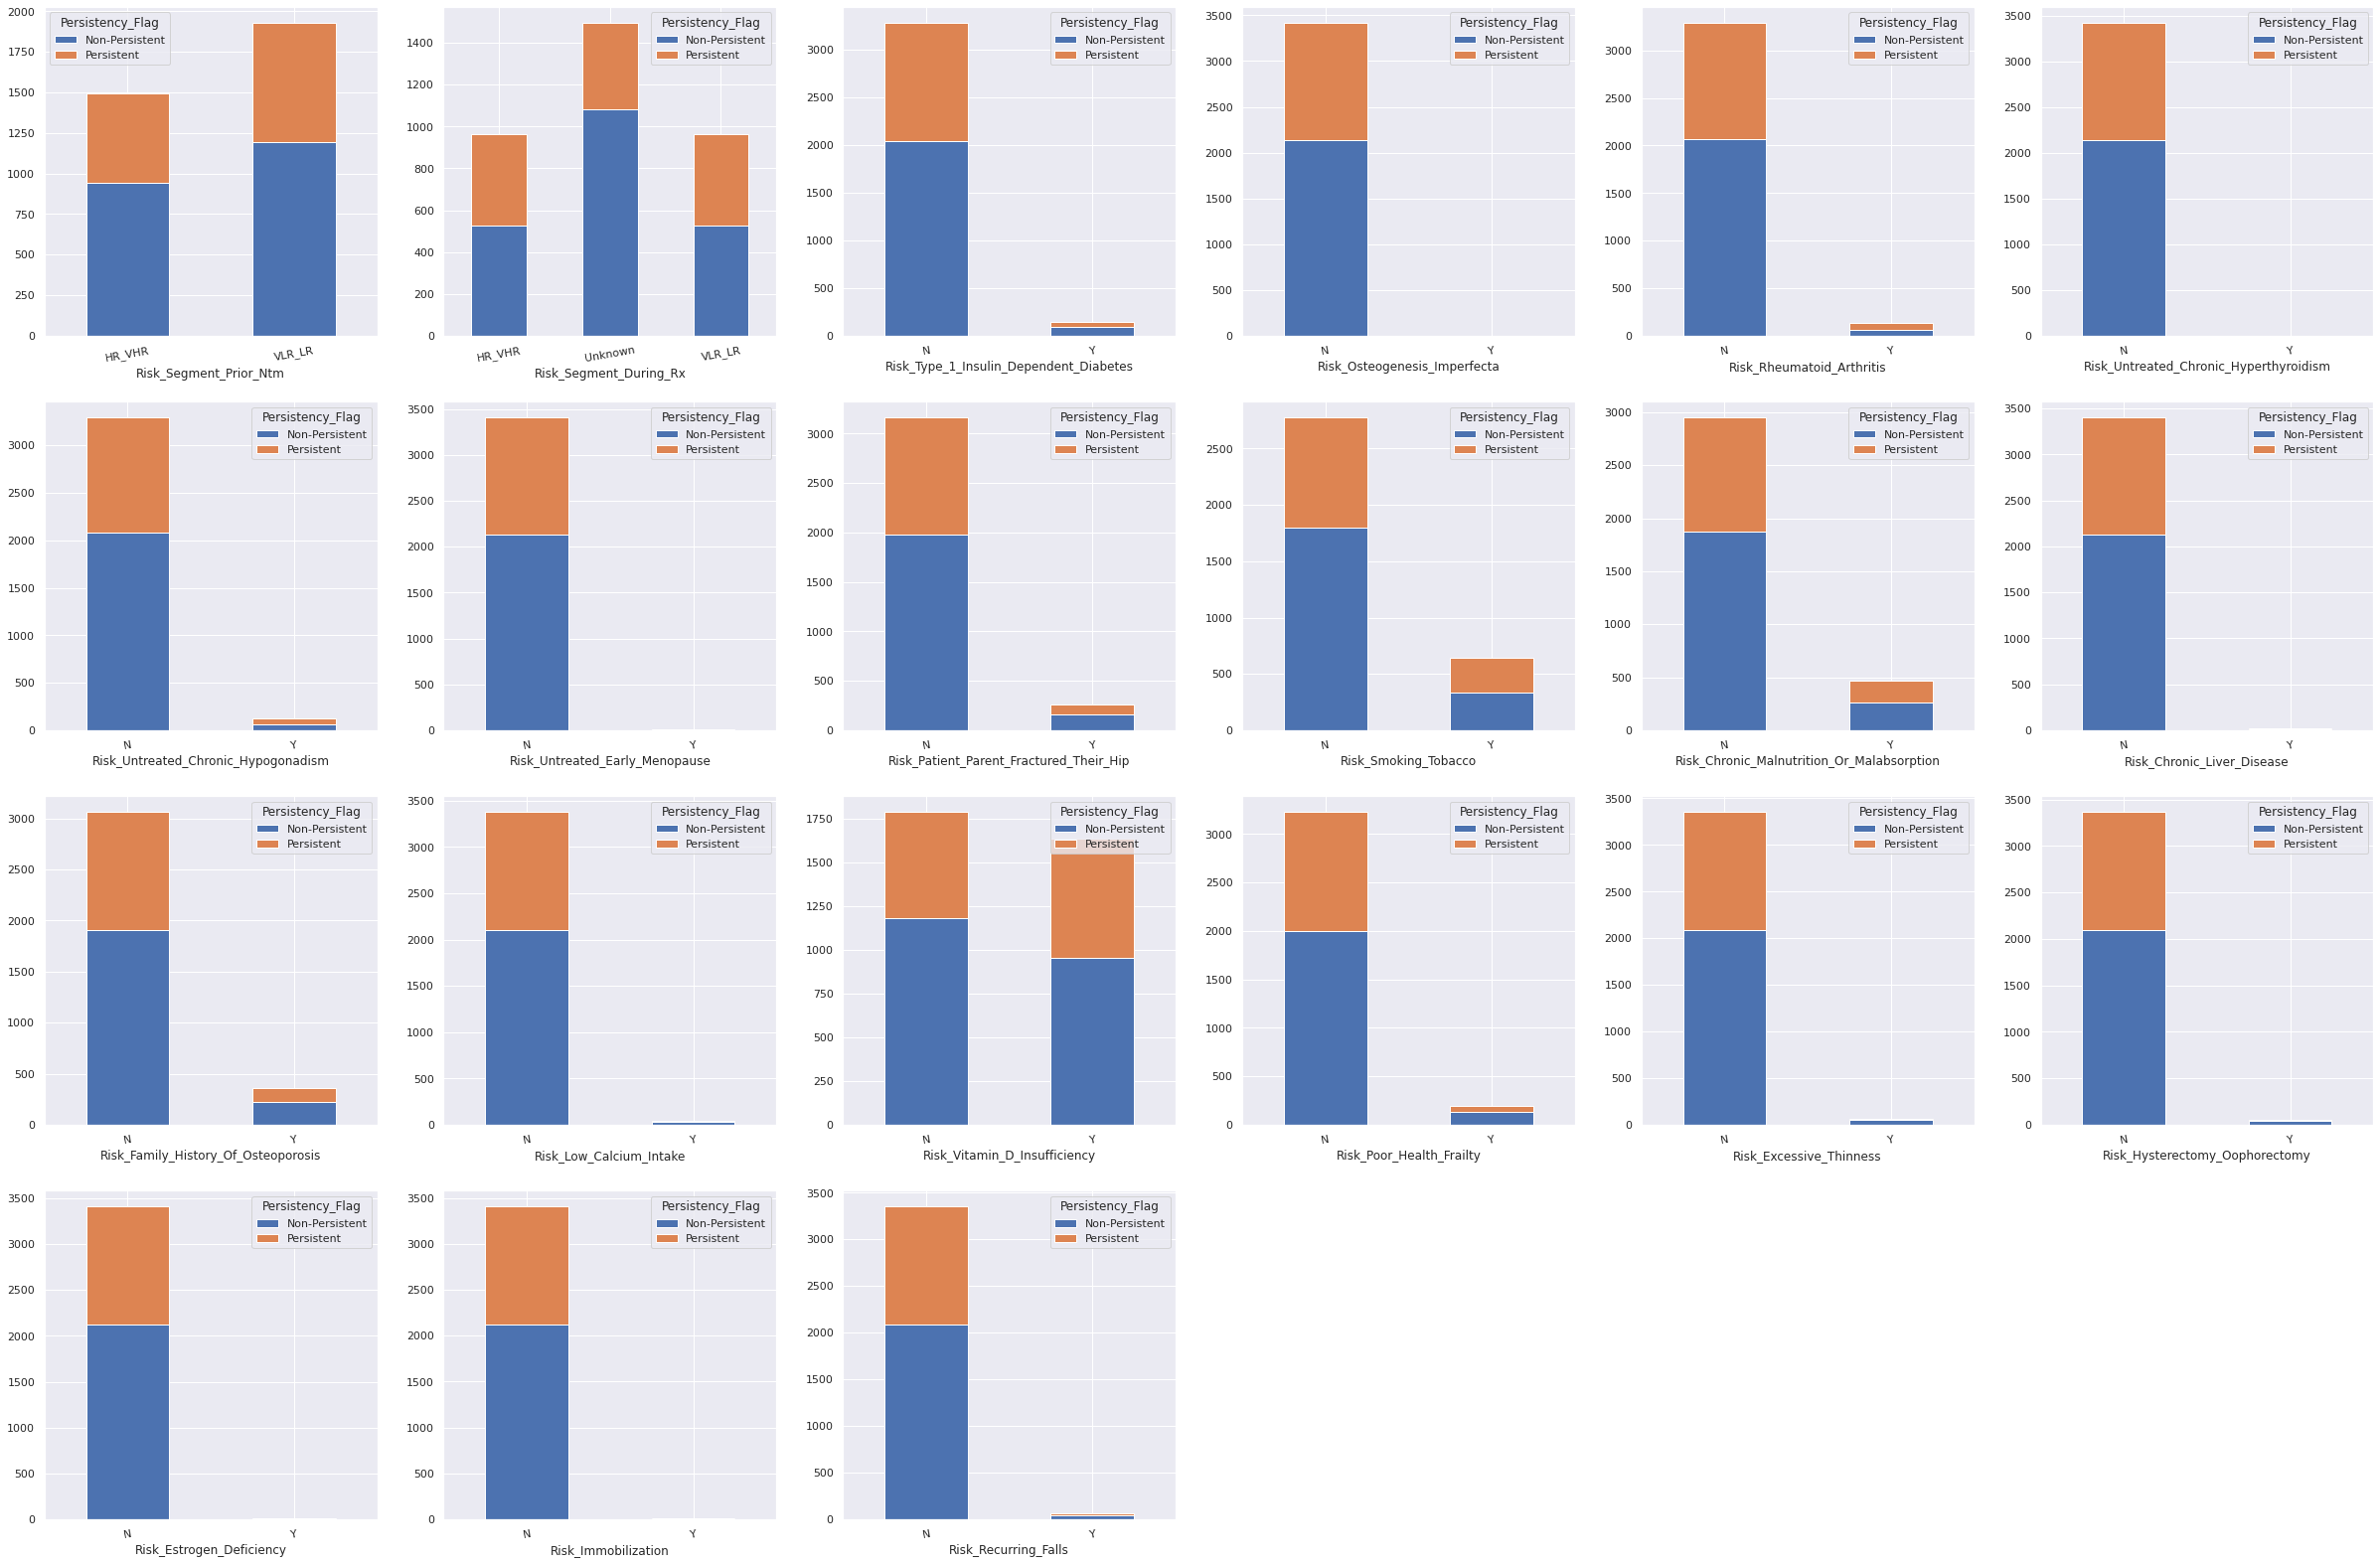

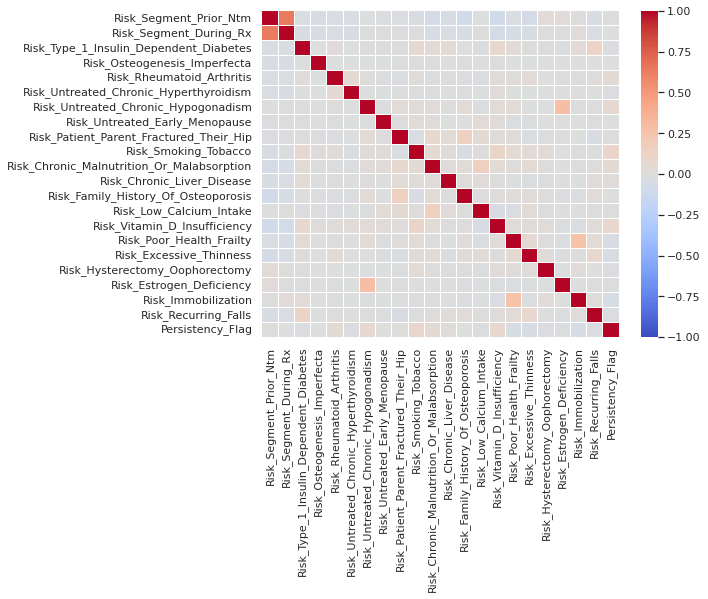

In [81]:
risk_colnames=[c for c in colnames if c.startswith("Risk")]

plot_stacked_bars(raw_df,risk_colnames)

corr_heatmap(corr,risk_colnames,False)

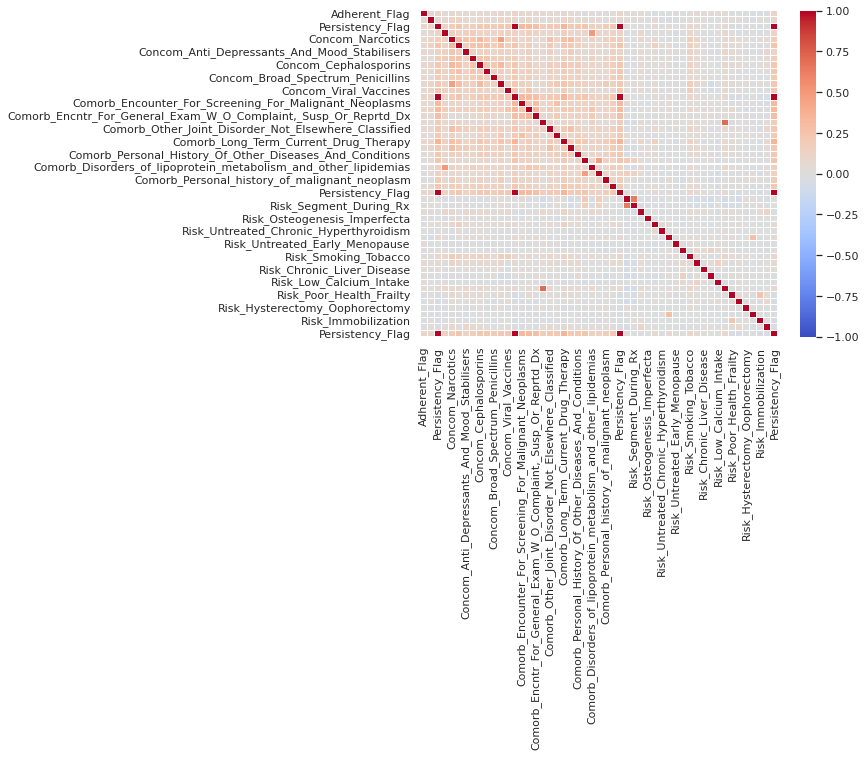

In [82]:
corr_heatmap(corr,other_disease_colnames+concom_colnames+comorb_colnames+risk_colnames,False)

In [83]:
disease_colnames=other_disease_colnames+concom_colnames+comorb_colnames+risk_colnames

strong_cors = generate_strong_correlations(corr.loc[disease_colnames,disease_colnames], 0.3)
# pprint_dict(strong_cors)

in_strong_cors,de_strong_cors,high_cor_colnames=categorize_correlations(strong_cors,[label])

pprint_dict(in_strong_cors)
pprint_dict(de_strong_cors)
print(high_cor_colnames)

"""
('Comorb_Dorsalgia', 'Concom_Narcotics') : 0.30255887279975663
('Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias', 'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations') : 0.5072828632253509
('Risk_Vitamin_D_Insufficiency', 'Comorb_Vitamin_D_Deficiency') : 0.7158648719608341
"""


('Concom_Systemic_Corticosteroids_Plain', 'Concom_Narcotics') : 0.3205396352914197
('Concom_Cephalosporins', 'Concom_Narcotics') : 0.32560840535914604
('Concom_Anaesthetics_General', 'Concom_Narcotics') : 0.47329946192299516
('Concom_Anaesthetics_General', 'Concom_Cephalosporins') : 0.3275245069097488
('Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Encounter_For_Immunization') : 0.34838941045288074
('Comorb_Dorsalgia', 'Concom_Narcotics') : 0.30255887279975663
('Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias', 'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations') : 0.5072828632253509
('Comorb_Osteoporosis_without_current_pathological_fracture', 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure') : 0.4808963285091766
('Risk_Segment_During_Rx', 'Risk_Segment_Prior_Ntm') : 0.6442959672850318
('Risk_Vitamin_D_Insufficiency', 'Comorb_Vitamin_D_Deficiency') : 0.7158648719608341


('Persistency_Flag', 'Comorb_Encounter_For_Screening_F

"\n('Comorb_Dorsalgia', 'Concom_Narcotics') : 0.30255887279975663\n('Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias', 'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations') : 0.5072828632253509\n('Risk_Vitamin_D_Insufficiency', 'Comorb_Vitamin_D_Deficiency') : 0.7158648719608341\n"

## Simple stat analysis

In [84]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 68 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Persistency_Flag                                                    3424 non-null   object
 1   Gender                                                              3424 non-null   object
 2   Race                                                                3424 non-null   object
 3   Ethnicity                                                           3424 non-null   object
 4   Region                                                              3424 non-null   object
 5   Age_Bucket                                                          3424 non-null   object
 6   Ntm_Speciality                                                      3424 non-null   object
 7   Ntm_Specialist_Flag     

Non-Persistent    2135
Persistent        1289
Name: Persistency_Flag, dtype: int64

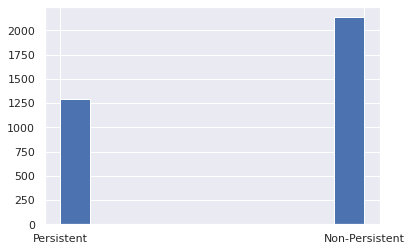

In [85]:
raw_df[label].hist();
raw_df[label].value_counts()

In [86]:
show_describe(raw_df)

shape: 3424


head info:
  Persistency_Flag  Gender           Race     Ethnicity   Region Age_Bucket  \
0       Persistent    Male      Caucasian  Not Hispanic     West        >75   
1   Non-Persistent    Male          Asian  Not Hispanic     West      55-65   
2   Non-Persistent  Female  Other/Unknown      Hispanic  Midwest      65-75   
3   Non-Persistent  Female      Caucasian  Not Hispanic  Midwest        >75   
4   Non-Persistent  Female      Caucasian  Not Hispanic  Midwest        >75   

         Ntm_Speciality Ntm_Specialist_Flag      Ntm_Speciality_Bucket  \
0  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
1  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
2  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
3  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
4  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   

  Gluco_Record_Prior_Ntm  ... Risk_Family_History_Of_Os

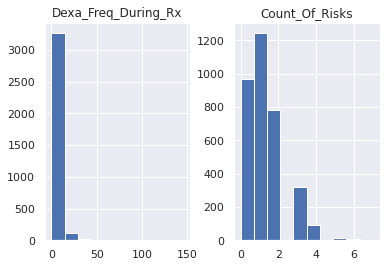

In [87]:
raw_df.hist();

## CORR

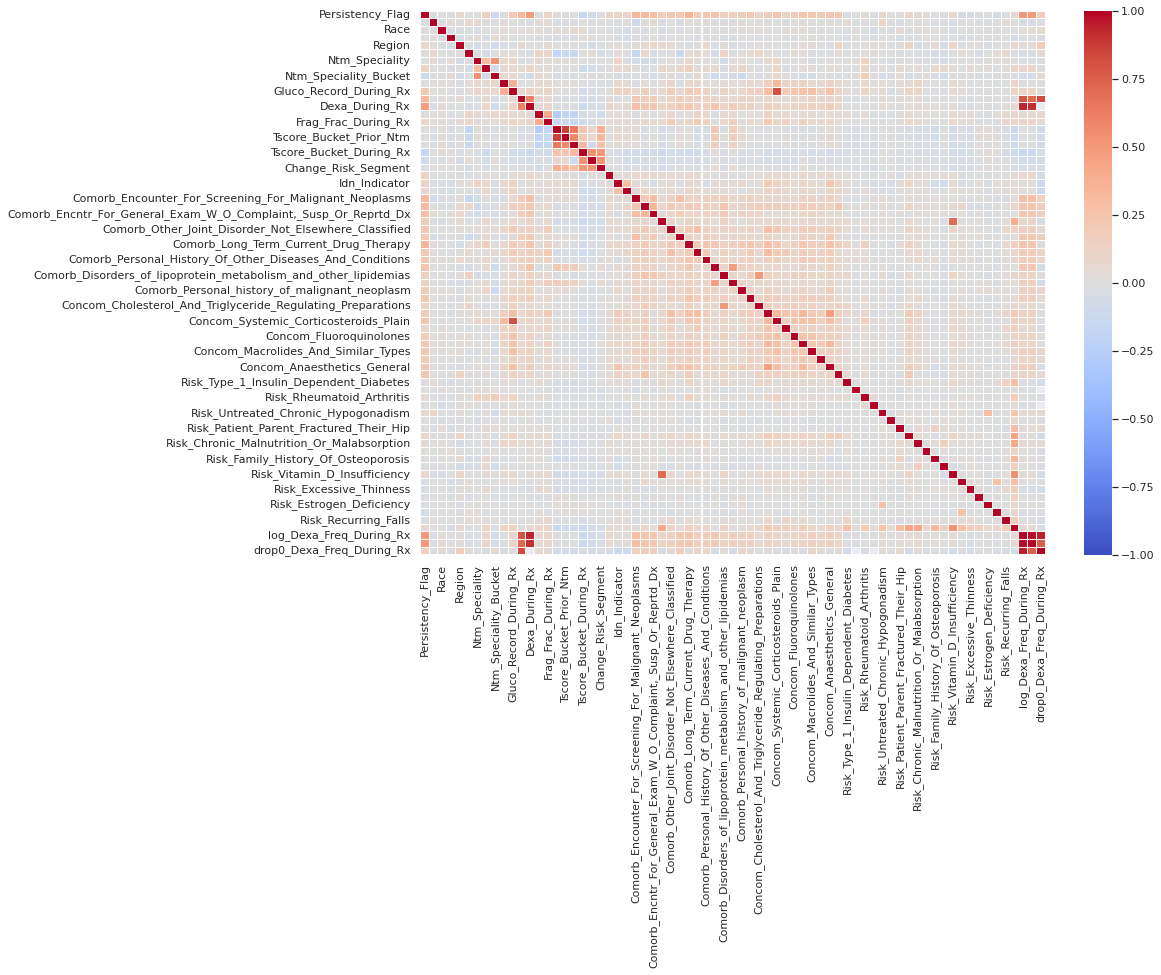

In [88]:

f, ax= plt.subplots(figsize = (14, 10))
sns.heatmap(corr,vmax=1.0, vmin=-1.0, cmap='coolwarm', linewidths = 0.02, ax = ax); #'RdBu' annot=True,

In [89]:
corr["Persistency_Flag"].sort_values()

Tscore_Bucket_During_Rx                 -0.151677
Ntm_Speciality_Bucket                   -0.112617
Change_T_Score                          -0.090298
Risk_Immobilization                     -0.049787
Risk_Poor_Health_Frailty                -0.045277
                                           ...   
Comorb_Long_Term_Current_Drug_Therapy    0.352760
Dexa_During_Rx                           0.491823
log_Dexa_Freq_During_Rx                  0.503177
cap_Dexa_Freq_During_Rx                  0.503882
Persistency_Flag                         1.000000
Name: Persistency_Flag, Length: 71, dtype: float64

In [90]:
strong_cors = generate_strong_correlations(corr, 0.3)
# pprint_dict(strong_cors)

in_strong_cors,de_strong_cors,high_cor_colnames=categorize_correlations(strong_cors,[label])

pprint_dict(in_strong_cors)
pprint_dict(de_strong_cors)
print(high_cor_colnames)


('Ntm_Specialist_Flag', 'Ntm_Speciality') : 0.3123047240503278
('Ntm_Speciality_Bucket', 'Ntm_Speciality') : 0.5360970440220538
('Gluco_Record_During_Rx', 'Gluco_Record_Prior_Ntm') : 0.3751337660990492
('Dexa_During_Rx', 'Dexa_Freq_During_Rx') : 0.6044370574623784
('Frag_Frac_During_Rx', 'Frag_Frac_Prior_Ntm') : 0.4098653134747994
('Tscore_Bucket_Prior_Ntm', 'Risk_Segment_Prior_Ntm') : 0.8668411471778542
('Risk_Segment_During_Rx', 'Risk_Segment_Prior_Ntm') : 0.6442959672850318
('Risk_Segment_During_Rx', 'Tscore_Bucket_Prior_Ntm') : 0.5816442630244841
('Tscore_Bucket_During_Rx', 'Risk_Segment_During_Rx') : 0.3211906632555133
('Change_T_Score', 'Tscore_Bucket_During_Rx') : 0.5503637923055041
('Change_Risk_Segment', 'Risk_Segment_Prior_Ntm') : 0.38558850379300563
('Change_Risk_Segment', 'Tscore_Bucket_Prior_Ntm') : 0.3396363669697802
('Change_Risk_Segment', 'Tscore_Bucket_During_Rx') : 0.5245735268740853
('Change_Risk_Segment', 'Change_T_Score') : 0.5346909739762303
('Comorb_Encntr_For_G

# Map

In [91]:
df,map_cs=hard_code(raw_df,str_colnames)

In [92]:
df_skew=df[colnames].skew()

df_skew[df_skew>3]

df_skew[df_skew>3].index

Index(['Gender', 'Dexa_Freq_During_Rx', 'Adherent_Flag',
       'Risk_Type_1_Insulin_Dependent_Diabetes',
       'Risk_Osteogenesis_Imperfecta', 'Risk_Rheumatoid_Arthritis',
       'Risk_Untreated_Chronic_Hyperthyroidism',
       'Risk_Untreated_Chronic_Hypogonadism', 'Risk_Untreated_Early_Menopause',
       'Risk_Patient_Parent_Fractured_Their_Hip', 'Risk_Chronic_Liver_Disease',
       'Risk_Low_Calcium_Intake', 'Risk_Poor_Health_Frailty',
       'Risk_Excessive_Thinness', 'Risk_Hysterectomy_Oophorectomy',
       'Risk_Estrogen_Deficiency', 'Risk_Immobilization',
       'Risk_Recurring_Falls'],
      dtype='object')

## TBC - map specific columns

In [93]:
binary_colnames=[k for k,d in map_cs.items() if len(d)==2]
multi_colnames=[k for k,d in map_cs.items() if len(d)>2]
smap_colnames=multi_colnames+["Adherent_Flag"]

In [94]:
# map
"""
Adherent_Flag= Ad:0 Non-:1



'Race',
'Ethnicity',
'Region',
'Age_Bucket', ~
'Ntm_Speciality_Bucket',
'Risk_Segment_During_Rx',
'Tscore_Bucket_During_Rx',
'Change_T_Score',
'Change_Risk_Segment'
"""

"\nAdherent_Flag= Ad:0 Non-:1\n\n\n\n'Race',\n'Ethnicity',\n'Region',\n'Age_Bucket', ~\n'Ntm_Speciality_Bucket',\n'Risk_Segment_During_Rx',\n'Tscore_Bucket_During_Rx',\n'Change_T_Score',\n'Change_Risk_Segment'\n"

In [95]:
pprint(multi_colnames)

['Race',
 'Ethnicity',
 'Region',
 'Age_Bucket',
 'Ntm_Speciality',
 'Ntm_Speciality_Bucket',
 'Risk_Segment_During_Rx',
 'Tscore_Bucket_During_Rx',
 'Change_T_Score',
 'Change_Risk_Segment']


In [96]:
col='Adherent_Flag'
map_cs[col]

{'Adherent': 0, 'Non-Adherent': 1}

In [97]:
smap_cs={'Adherent_Flag': {'Adherent': 1, 'Non-Adherent': 0}
         

}
d=smap_cs[col]
raw_df[col].apply(lambda x: d[x])

0       1
1       1
2       1
3       1
4       1
       ..
3419    1
3420    0
3421    1
3422    1
3423    1
Name: Adherent_Flag, Length: 3424, dtype: int64

In [98]:
col='Risk_Type_1_Insulin_Dependent_Diabetes'

def show_dist(col):
    print(raw_df[col].value_counts())
    print(len(raw_df[col].unique()))
    print(raw_df[col].unique())

In [99]:
show_dist('Risk_Untreated_Chronic_Hyperthyroidism')

N    3422
Y       2
Name: Risk_Untreated_Chronic_Hyperthyroidism, dtype: int64
2
['N' 'Y']


In [100]:
"""
    'Risk_Type_1_Insulin_Dependent_Diabetes'
    'Risk_Osteogenesis_Imperfecta'
    'Risk_Rheumatoid_Arthritis'
    'Risk_Untreated_Chronic_Hyperthyroidism'
    'Risk_Untreated_Chronic_Hypogonadism'
    'Risk_Untreated_Early_Menopause'
    'Risk_Patient_Parent_Fractured_Their_Hip'
    'Risk_Smoking_Tobacco'
    'Risk_Chronic_Malnutrition_Or_Malabsorption'
    'Risk_Chronic_Liver_Disease'
    'Risk_Family_History_Of_Osteoporosis'
    'Risk_Low_Calcium_Intake'
    'Risk_Vitamin_D_Insufficiency'
    'Risk_Poor_Health_Frailty'
    'Risk_Excessive_Thinness'
    'Risk_Hysterectomy_Oophorectomy'
    'Risk_Estrogen_Deficiency'
    'Risk_Immobilization'
    'Risk_Recurring_Falls'
"""
uni_colnames=[]
# Risk
for col in binary_colnames:
    if len(raw_df[col].unique())==1:
        uni_colnames.append(col)
    # if col.startswith('Risk_')):
        
uni_colnames = []

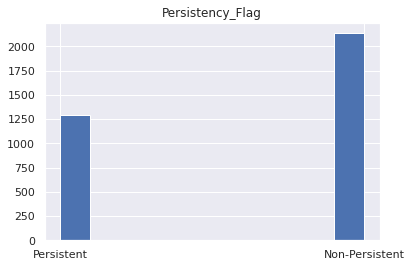

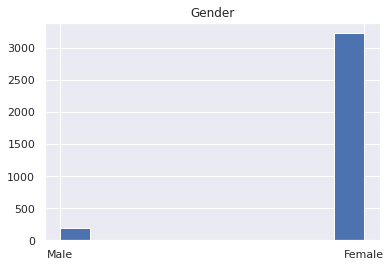

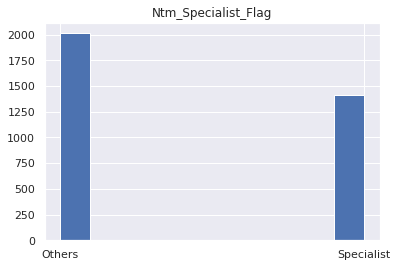

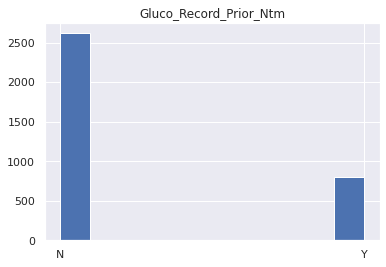

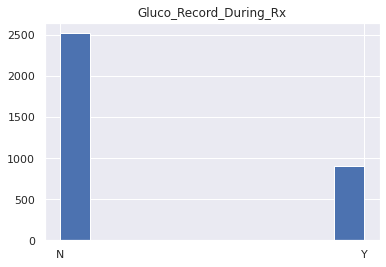

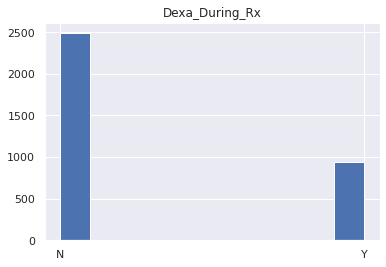

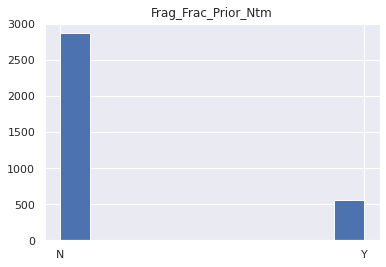

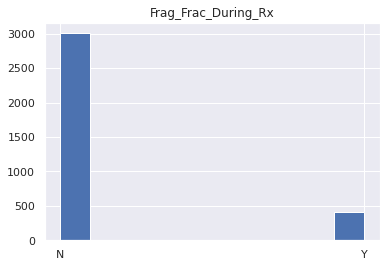

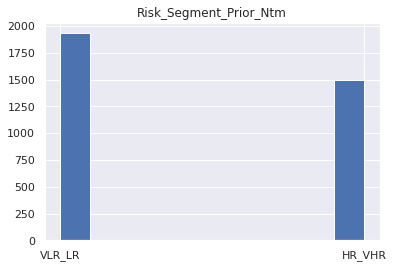

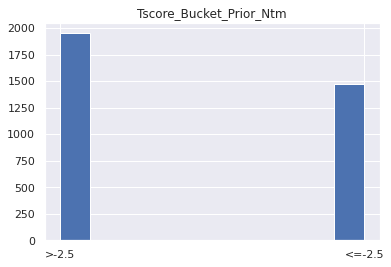

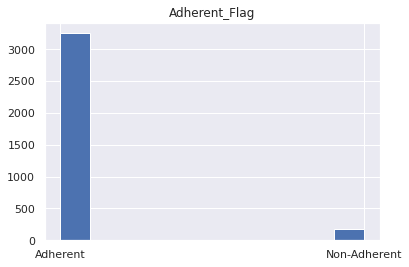

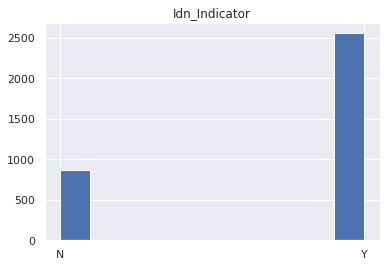

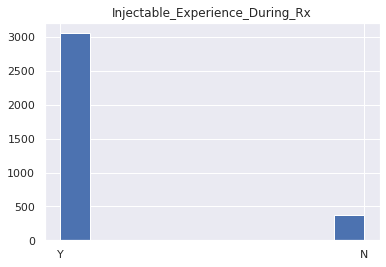

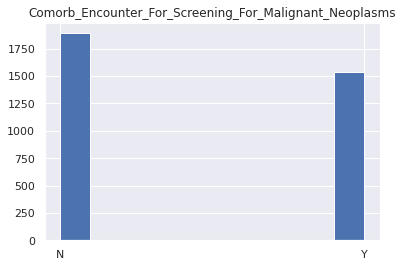

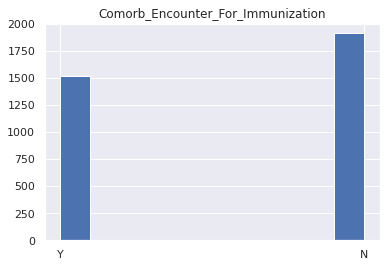

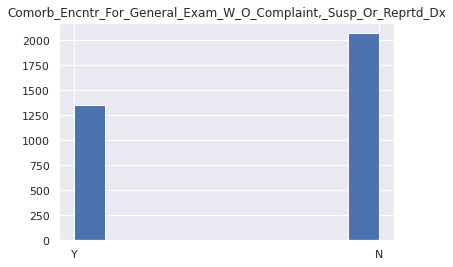

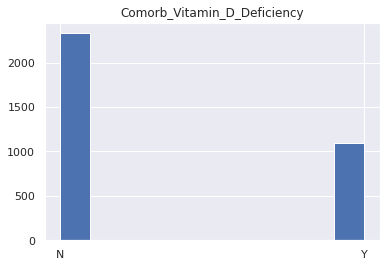

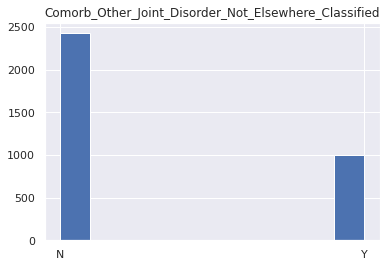

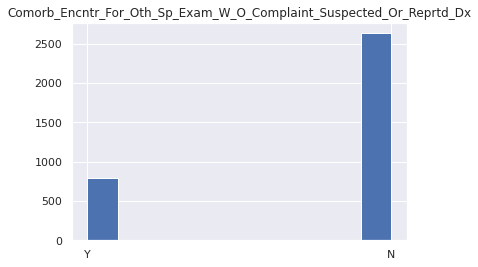

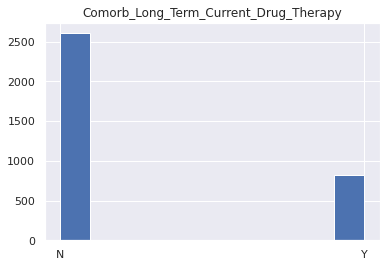

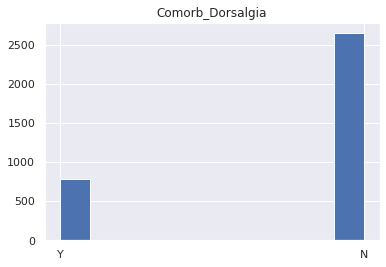

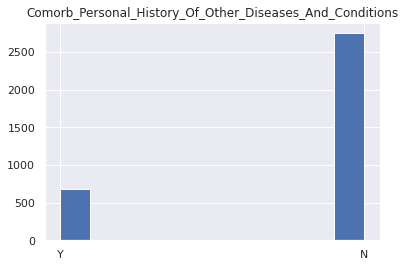

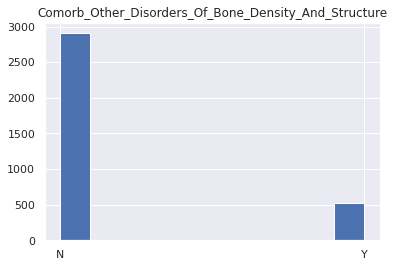

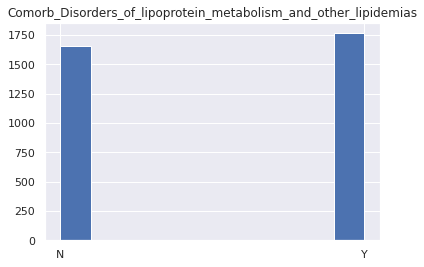

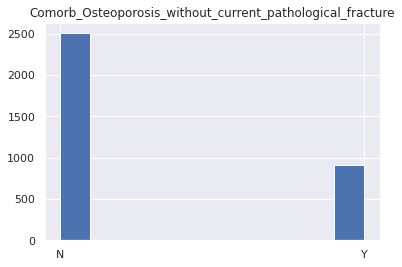

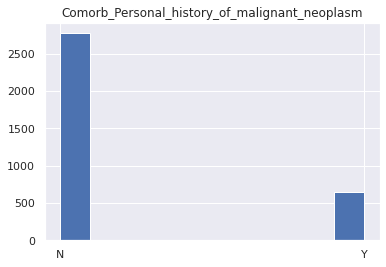

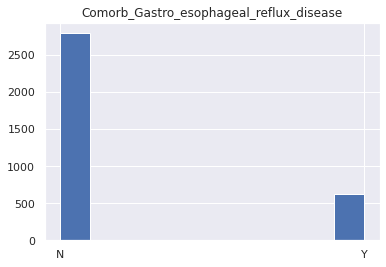

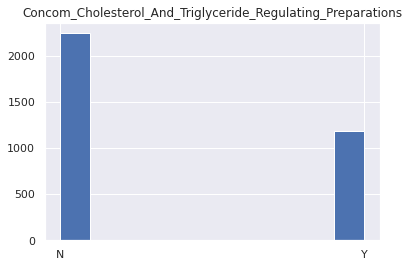

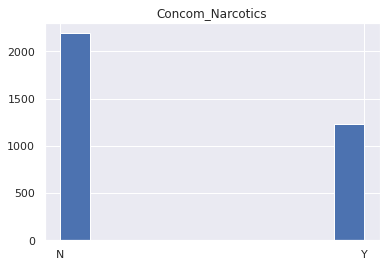

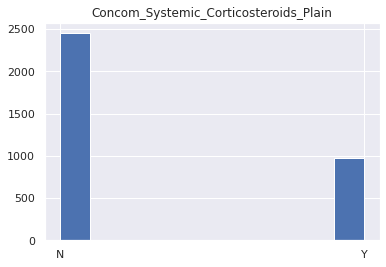

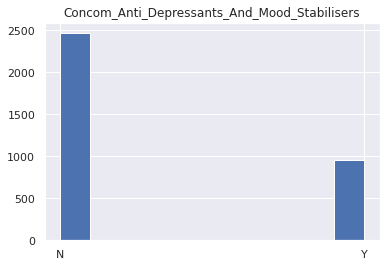

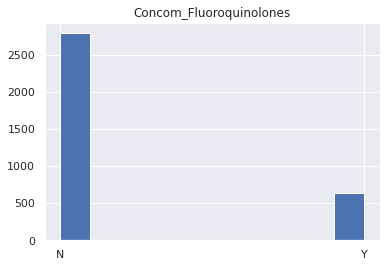

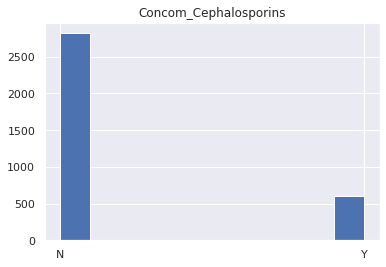

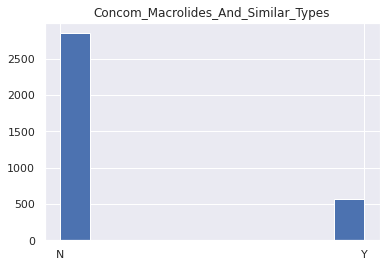

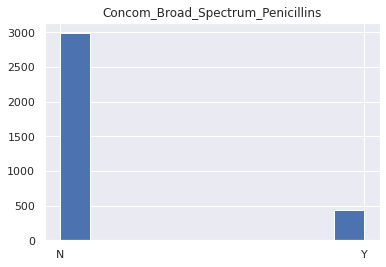

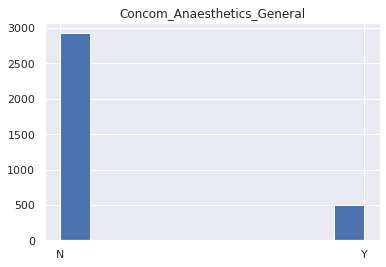

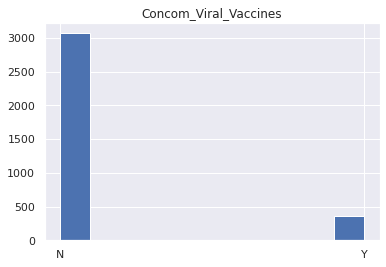

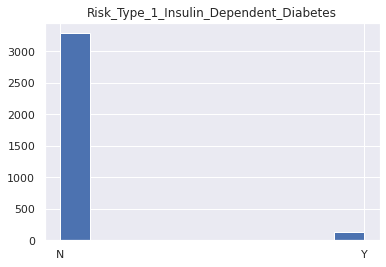

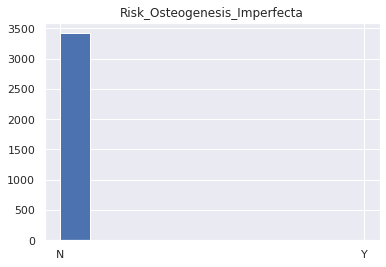

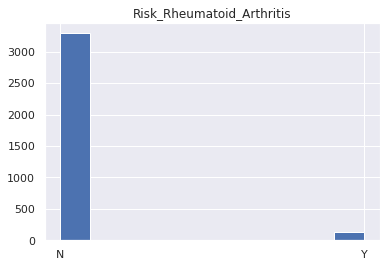

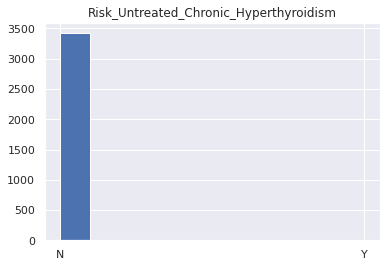

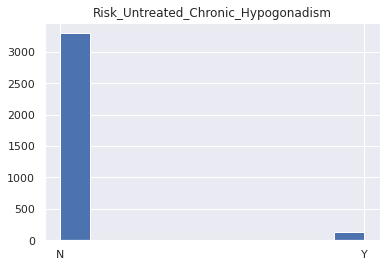

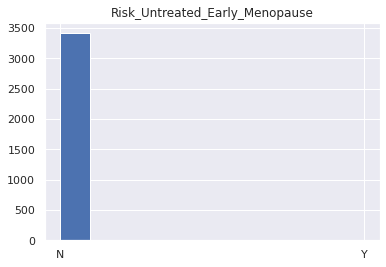

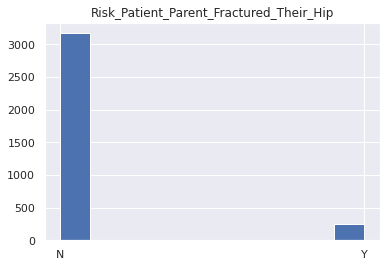

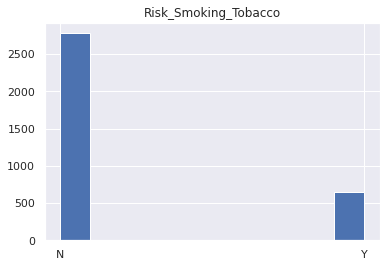

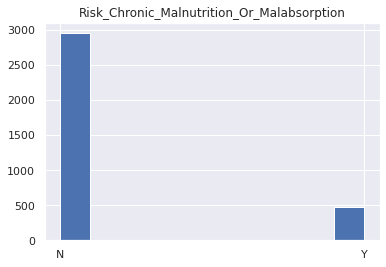

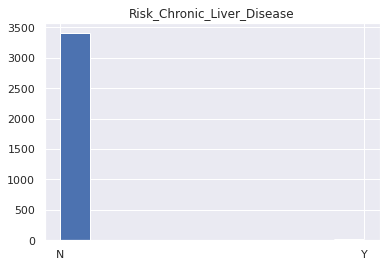

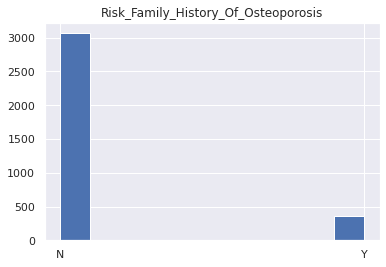

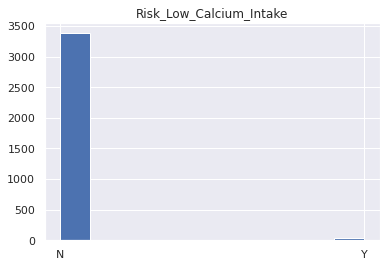

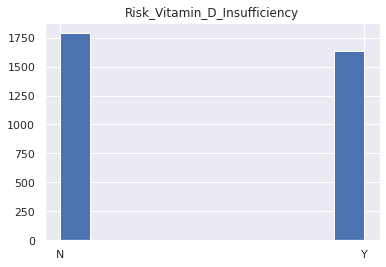

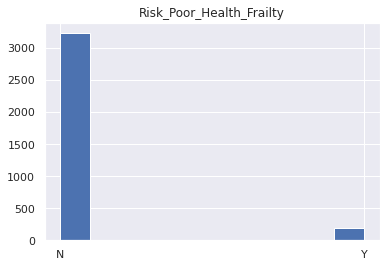

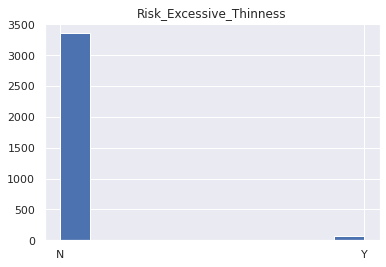

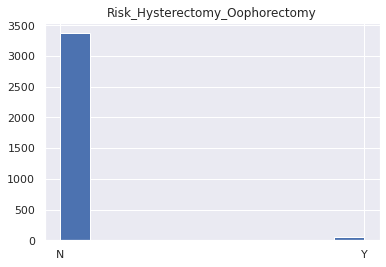

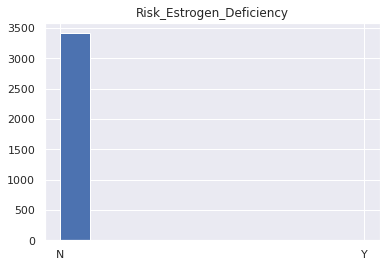

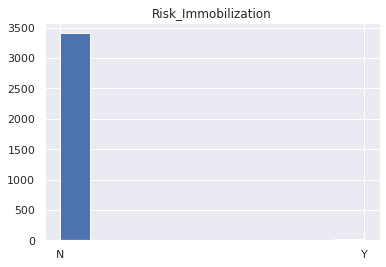

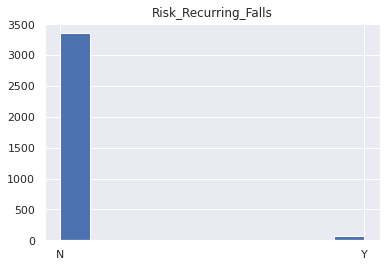

In [101]:
for col in binary_colnames:
    raw_df[col].hist();
    plt.title(col)
    plt.show()

In [102]:
pprint(map_cs)

{'Adherent_Flag': {'Adherent': 0, 'Non-Adherent': 1},
 'Age_Bucket': {'55-65': 0, '65-75': 1, '<55': 2, '>75': 3},
 'Change_Risk_Segment': {'Improved': 0,
                         'No change': 1,
                         'Unknown': 2,
                         'Worsened': 3},
 'Change_T_Score': {'Improved': 0, 'No change': 1, 'Unknown': 2, 'Worsened': 3},
 'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias': {'N': 0,
                                                                     'Y': 1},
 'Comorb_Dorsalgia': {'N': 0, 'Y': 1},
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx': {'N': 0,
                                                                     'Y': 1},
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx': {'N': 0,
                                                                        'Y': 1},
 'Comorb_Encounter_For_Immunization': {'N': 0, 'Y': 1},
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms': {'N': 0, 'Y': 1},


# Train

In [103]:
raw_df[label].value_counts()

Non-Persistent    2135
Persistent        1289
Name: Persistency_Flag, dtype: int64

In [104]:
def generate_accs(model, X_train, y_train, X_test, y_test, show=True):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    if show: print(f"train set acc: {train_acc} test set acc: {test_acc}")
    return train_acc, test_acc


test_size=0.2
X=df[inde_colnames]#cor_df[inde_colnames]
y=raw_df[label]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=265)

In [105]:
kwargs={
    'criterion' :'entropy',
    'n_estimators':100,
    'n_jobs':-1,
    'max_depth':15,
    'random_state':265}

rf=RandomForestClassifier(**kwargs)

rf.fit(X_train,y_train)

y_pred=rf.predict(X_test)

generate_accs(rf,X_train, y_train, X_test, y_test)

train set acc: 0.9802847754654983 test set acc: 0.8291970802919708


(0.9802847754654983, 0.8291970802919708)

In [106]:
def visualize_cm(matrix):
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ["Non-Persistent","Persistent"]
    tick_marks = np.arange(len(class_names))+0.5
    tick_marks2 = tick_marks
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()

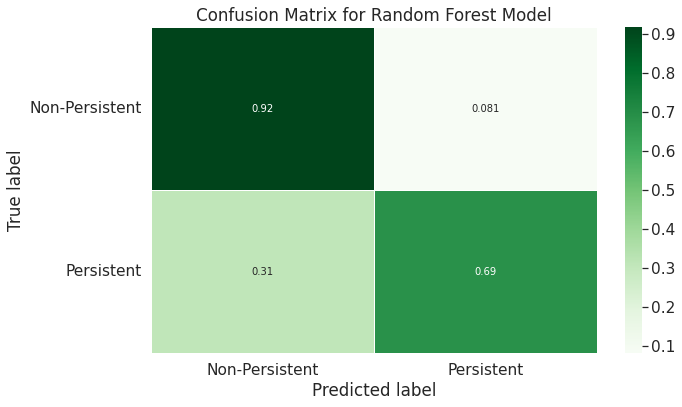

In [107]:
cm = confusion_matrix(y_test, y_pred)

visualize_cm(cm)